# Using Machine Learning

## INITIALISATION


In [318]:
import yfinance as yf
import pandas as pd
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ta.momentum import RSIIndicator
from ta.trend import MACD
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit     
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)


In [267]:
symbols = ["RELIANCE.NS", "HDFCBANK.NS", "INFY.NS"]

In [268]:
for symbol in symbols:   
    stock = yf.Ticker(symbol)
    info = stock.info
    print(f"Symbol: {symbol}")
    print(f"Name: {info.get('shortName', 'N/A')}")
    print(f"Market: {info.get('market', 'N/A')}")
    print(f"Sector: {info.get('sector', 'N/A')}")
    print("-" * 30)

Symbol: RELIANCE.NS
Name: RELIANCE INDUSTRIES LTD
Market: in_market
Sector: Energy
------------------------------
Symbol: HDFCBANK.NS
Name: HDFC BANK LTD
Market: in_market
Sector: Financial Services
------------------------------
Symbol: INFY.NS
Name: INFOSYS LIMITED
Market: in_market
Sector: Technology
------------------------------


## DATA VISUALISATION


Historical Data for HDFCBANK.NS for the last 6 months:
+---------------------------+----------+----------+----------+----------+-------------+-------------+----------------+
| Date                      |     Open |     High |      Low |    Close |      Volume |   Dividends |   Stock Splits |
|---------------------------+----------+----------+----------+----------+-------------+-------------+----------------|
| 2020-08-03 00:00:00+05:30 |  974.173 |  975.123 |  942.886 |  951.432 | 1.58918e+07 |           0 |              0 |
| 2020-08-04 00:00:00+05:30 |  957.129 | 1007.5   |  952.381 |  989.081 | 3.01531e+07 |           0 |              0 |
| 2020-08-05 00:00:00+05:30 |  995.063 | 1002.52  |  968.523 |  975.692 | 1.66107e+07 |           0 |              0 |
| 2020-08-06 00:00:00+05:30 |  984.665 | 1001.76  |  974.458 |  988.179 | 1.68234e+07 |           0 |              0 |
| 2020-08-07 00:00:00+05:30 |  982.624 |  994.351 |  969.093 |  991.17  | 1.24184e+07 |           0 |           

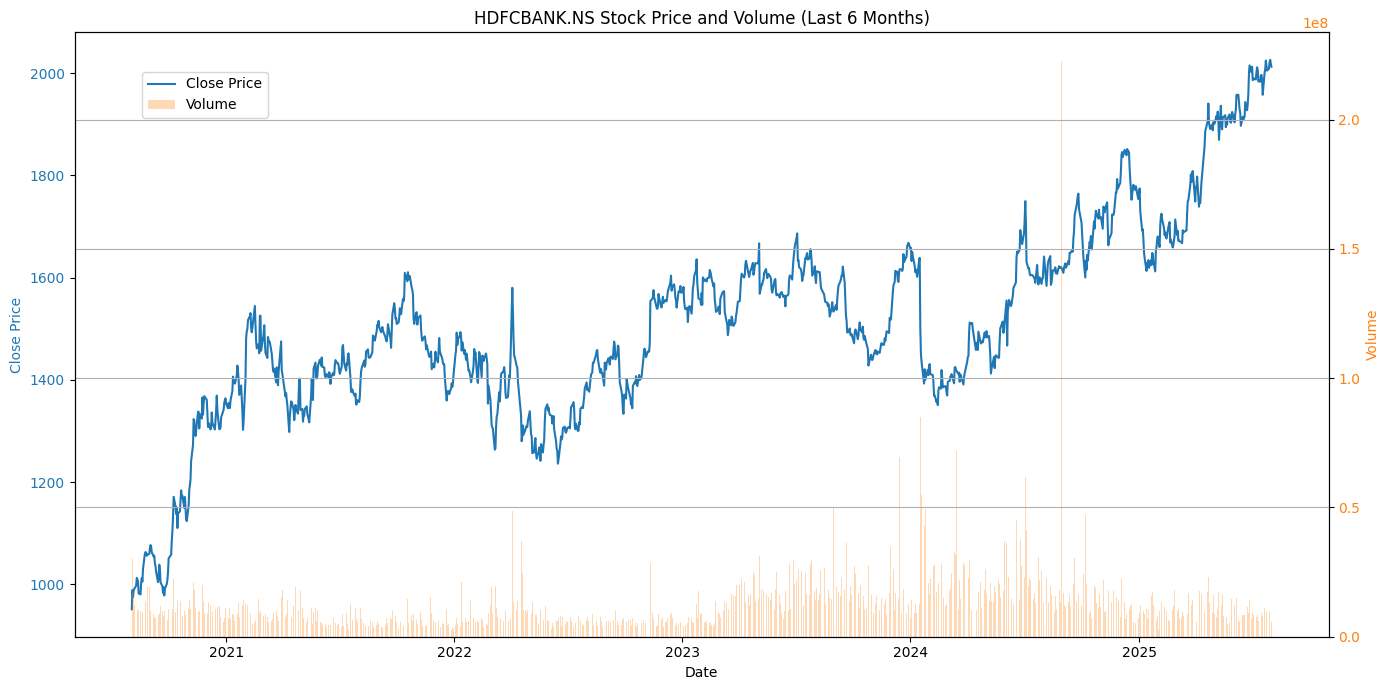

In [269]:
#we will fetch data for the last 6 months for each stock and plot the close price and volume
symbol = 'HDFCBANK.NS'
period = '5y'  

stock = yf.Ticker(symbol)
data = stock.history(period=period)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(f"Historical Data for {symbol} for the last 6 months:")
formatted_data = pd.concat([data.head(), data.tail()])
print(tabulate(formatted_data, headers='keys', tablefmt='psql'))


# Plotting the data
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.plot(data.index, data['Close'], color='tab:blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='tab:orange')
ax2.bar(data.index, data['Volume'], color='tab:orange', alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor='tab:orange')


plt.title(f'{symbol} Stock Price and Volume (Last 6 Months)')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.grid(True)
plt.show()

Historical Data for RELIANCE.NS for the last 6 months:
+---------------------------+----------+----------+----------+----------+-------------+-------------+----------------+
| Date                      |     Open |     High |      Low |    Close |      Volume |   Dividends |   Stock Splits |
|---------------------------+----------+----------+----------+----------+-------------+-------------+----------------|
| 2020-08-03 00:00:00+05:30 |  933.838 |  936.433 |  911.896 |  914.582 | 4.67154e+07 |           0 |              0 |
| 2020-08-04 00:00:00+05:30 |  919.862 |  986.51  |  910.598 |  979.044 | 9.20411e+07 |           0 |              0 |
| 2020-08-05 00:00:00+05:30 |  987.42  |  999.712 |  964.34  |  968.05  | 7.455e+07   |           0 |              0 |
| 2020-08-06 00:00:00+05:30 |  981.957 |  986.829 |  959.559 |  971.532 | 4.9323e+07  |           0 |              0 |
| 2020-08-07 00:00:00+05:30 |  969.575 |  982.322 |  965.205 |  977.155 | 3.29844e+07 |           0 |           

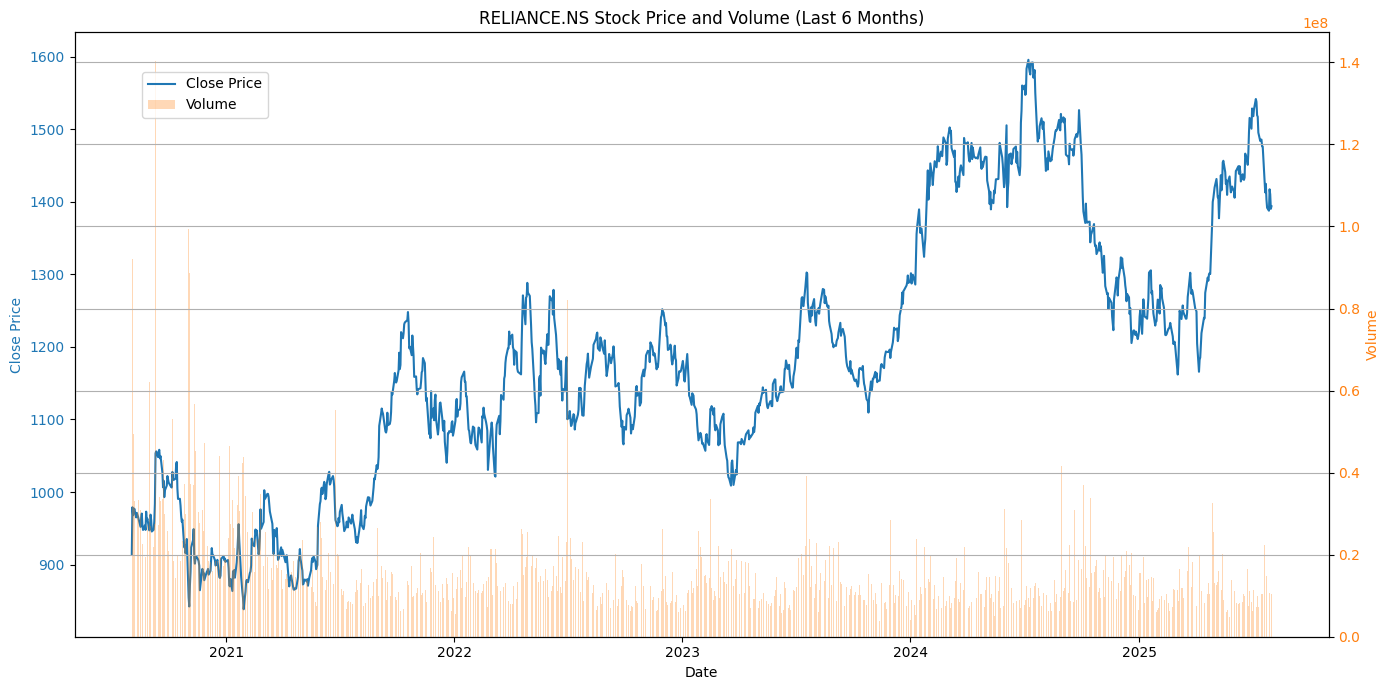

In [270]:
#we will fetch data for the last 6 months for each stock and plot the close price and volume
symbol = 'RELIANCE.NS'
period = '5y'  

stock = yf.Ticker(symbol)
data = stock.history(period=period)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(f"Historical Data for {symbol} for the last 6 months:")
formatted_data = pd.concat([data.head(), data.tail()])
print(tabulate(formatted_data, headers='keys', tablefmt='psql'))


# Plotting the data
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.plot(data.index, data['Close'], color='tab:blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='tab:orange')
ax2.bar(data.index, data['Volume'], color='tab:orange', alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor='tab:orange')


plt.title(f'{symbol} Stock Price and Volume (Last 6 Months)')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.grid(True)
plt.show()

Historical Data for INFY.NS for the last 6 months:
+---------------------------+----------+----------+----------+----------+-------------+-------------+----------------+
| Date                      |     Open |     High |      Low |    Close |      Volume |   Dividends |   Stock Splits |
|---------------------------+----------+----------+----------+----------+-------------+-------------+----------------|
| 2020-08-03 00:00:00+05:30 |  853.778 |  858.581 |  842.617 |  851.021 | 8.47979e+06 |           0 |              0 |
| 2020-08-04 00:00:00+05:30 |  854.179 |  863.294 |  836.48  |  844.751 | 1.11332e+07 |           0 |              0 |
| 2020-08-05 00:00:00+05:30 |  846.663 |  854.623 |  834.479 |  840.171 | 9.61418e+06 |           0 |              0 |
| 2020-08-06 00:00:00+05:30 |  847.998 |  866.585 |  838.215 |  863.428 | 1.09765e+07 |           0 |              0 |
| 2020-08-07 00:00:00+05:30 |  862.183 |  862.183 |  843.996 |  845.685 | 8.01095e+06 |           0 |              0

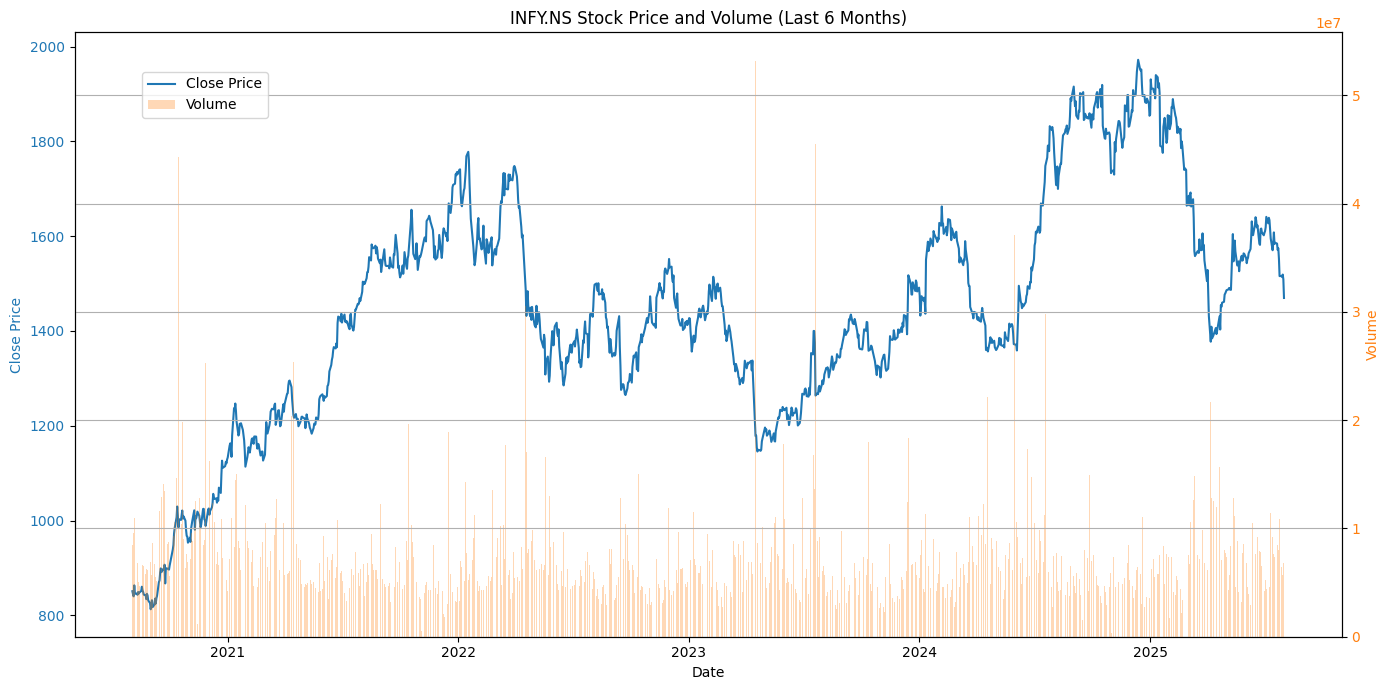

In [271]:
#we will fetch data for the last 6 months for each stock and plot the close price and volume
symbol = 'INFY.NS'
period = '5y'  

stock = yf.Ticker(symbol)
data = stock.history(period=period)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(f"Historical Data for {symbol} for the last 6 months:")
formatted_data = pd.concat([data.head(), data.tail()])
print(tabulate(formatted_data, headers='keys', tablefmt='psql'))


# Plotting the data
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.plot(data.index, data['Close'], color='tab:blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='tab:orange')
ax2.bar(data.index, data['Volume'], color='tab:orange', alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor='tab:orange')


plt.title(f'{symbol} Stock Price and Volume (Last 6 Months)')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.grid(True)
plt.show()

## PREPROCESSING THE DATA

In [342]:
# Define symbols and period
symbols = ["INFY.NS", "RELIANCE.NS", "HDFCBANK.NS"]
period = "5y"

# Preprocessing function
def preprocess_stock(df, rsi_threshold=35):
    df = df.copy()
    
    # Technical Indicators
    df["RSI"] = RSIIndicator(df["Close"], window=14).rsi()
    df["MACD"] = MACD(df["Close"]).macd()
    df["MACD_Signal"] = MACD(df["Close"]).macd_signal()
    df["SMA_20"] = df["Close"].rolling(window=20).mean()
    df["SMA_50"] = df["Close"].rolling(window=50).mean()
    df["EMA_20"] = df["Close"].ewm(span=20, adjust=False).mean()
    df["Volatility"] = df["Close"].rolling(window=10).std()
    
    # Strategy Signals (RSI < 35 and SMA_20 > SMA_50)
    df["Buy_Signal"] = ((df["RSI"] < rsi_threshold) & (df["SMA_20"] > df["SMA_50"])).astype(int)
    df["Logic_Signal"] = df["Buy_Signal"]  # For ML vs. Logic comparison
    df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)  # Next-day price increase
    
    # Ensure datetime index is timezone-aware
    df.index = pd.to_datetime(df.index).tz_convert("Asia/Kolkata")
    return df.dropna()

In [343]:
# Fetch and preprocess data for each stock
processed_data_dict = {}

for symbol in symbols:
    print(f"\nFetching data for {symbol}")
    data = yf.Ticker(symbol).history(period=period)
    if data.empty:
        print(f"Error: No data retrieved for {symbol}")
        continue
    processed_data = preprocess_stock(data)
    processed_data_dict[symbol] = processed_data
    print(f"Processed data for {symbol}: {len(processed_data)} rows")
    print(f"Data from {processed_data.index.min()} to {processed_data.index.max()}")
    print(f"Index timezone: {processed_data.index.tz}")
    print(f"\nSample processed data for {symbol}:")
    print(processed_data[["Close", "RSI", "MACD", "SMA_20", "SMA_50", "Buy_Signal", "Target"]].tail())


Fetching data for INFY.NS
Processed data for INFY.NS: 1191 rows
Data from 2020-10-12 00:00:00+05:30 to 2025-08-01 00:00:00+05:30
Index timezone: Asia/Kolkata

Sample processed data for INFY.NS:
                                 Close        RSI       MACD       SMA_20  \
Date                                                                        
2025-07-28 00:00:00+05:30  1516.000000  32.516792 -15.451989  1591.704999   
2025-07-29 00:00:00+05:30  1513.699951  32.118653 -18.410624  1587.049994   
2025-07-30 00:00:00+05:30  1519.000000  34.120385 -20.096039  1582.474994   
2025-07-31 00:00:00+05:30  1509.000000  32.191520 -21.985228  1576.989996   
2025-08-01 00:00:00+05:30  1469.599976  25.963703 -26.357839  1568.434998   

                                SMA_50  Buy_Signal  Target  
Date                                                        
2025-07-28 00:00:00+05:30  1585.859570           1       0  
2025-07-29 00:00:00+05:30  1585.354634           1       1  
2025-07-30 00:00:00+0

In [344]:
# Access processed DataFrames
processed_infy = processed_data_dict.get("INFY.NS")
processed_reliance = processed_data_dict.get("RELIANCE.NS")
processed_hdfcbank = processed_data_dict.get("HDFCBANK.NS")


Plotting technical indicators for INFY.NS (122 data points)


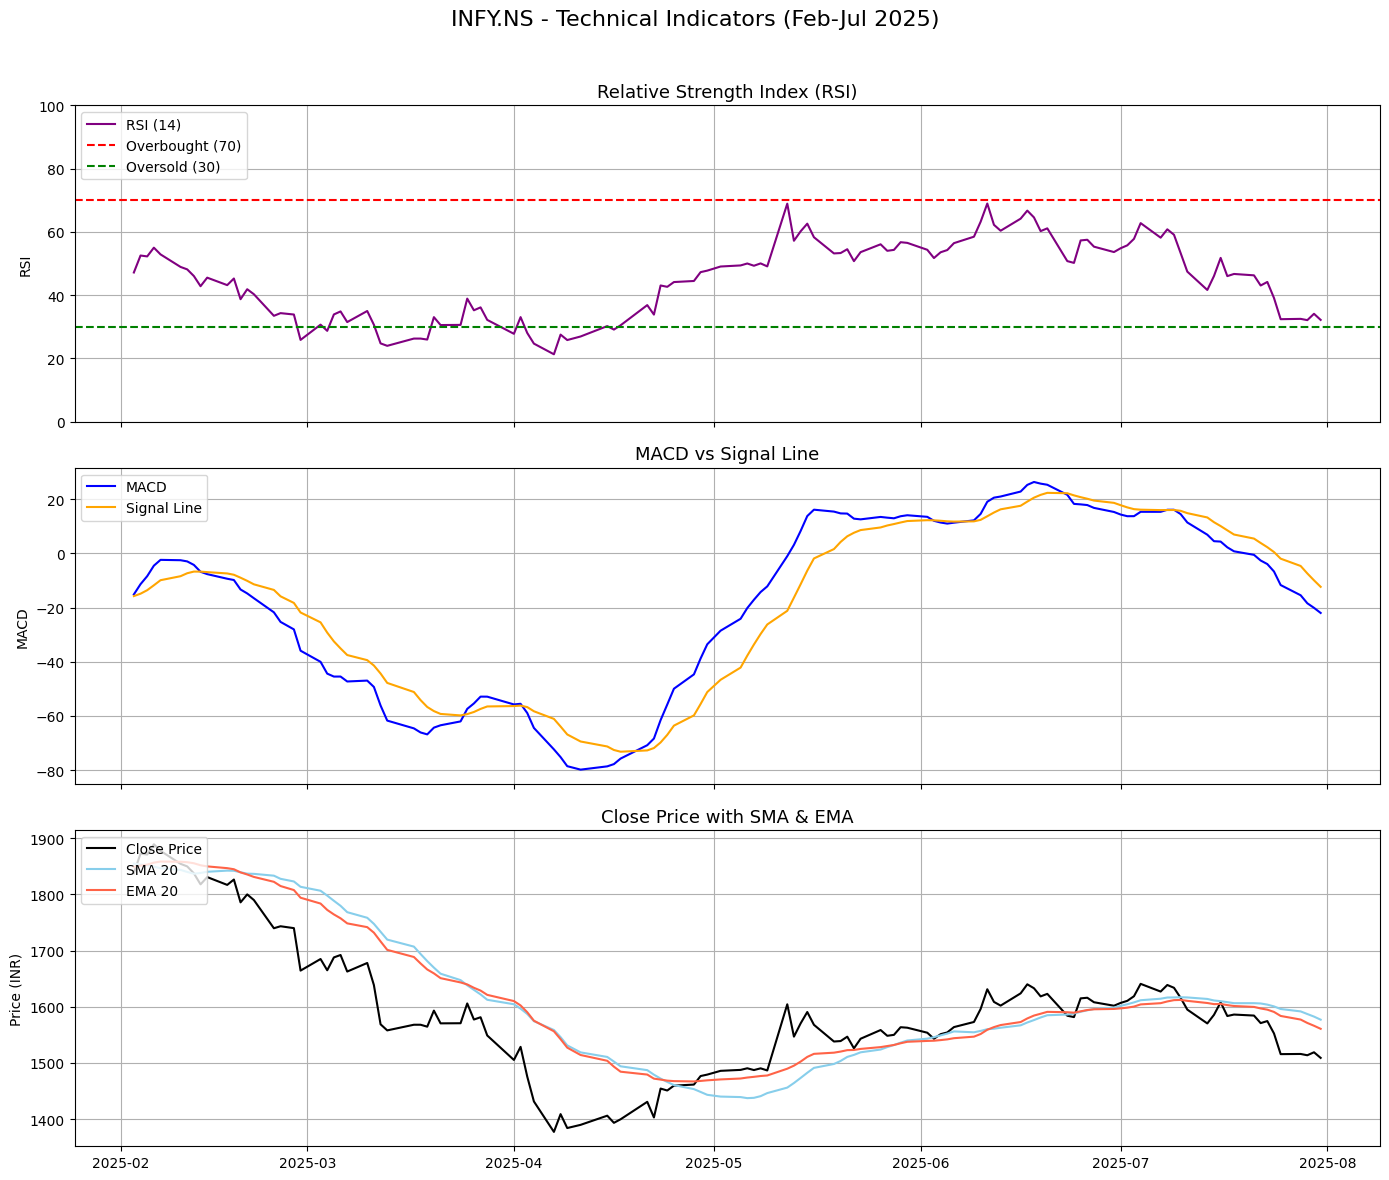


Plotting technical indicators for RELIANCE.NS (122 data points)


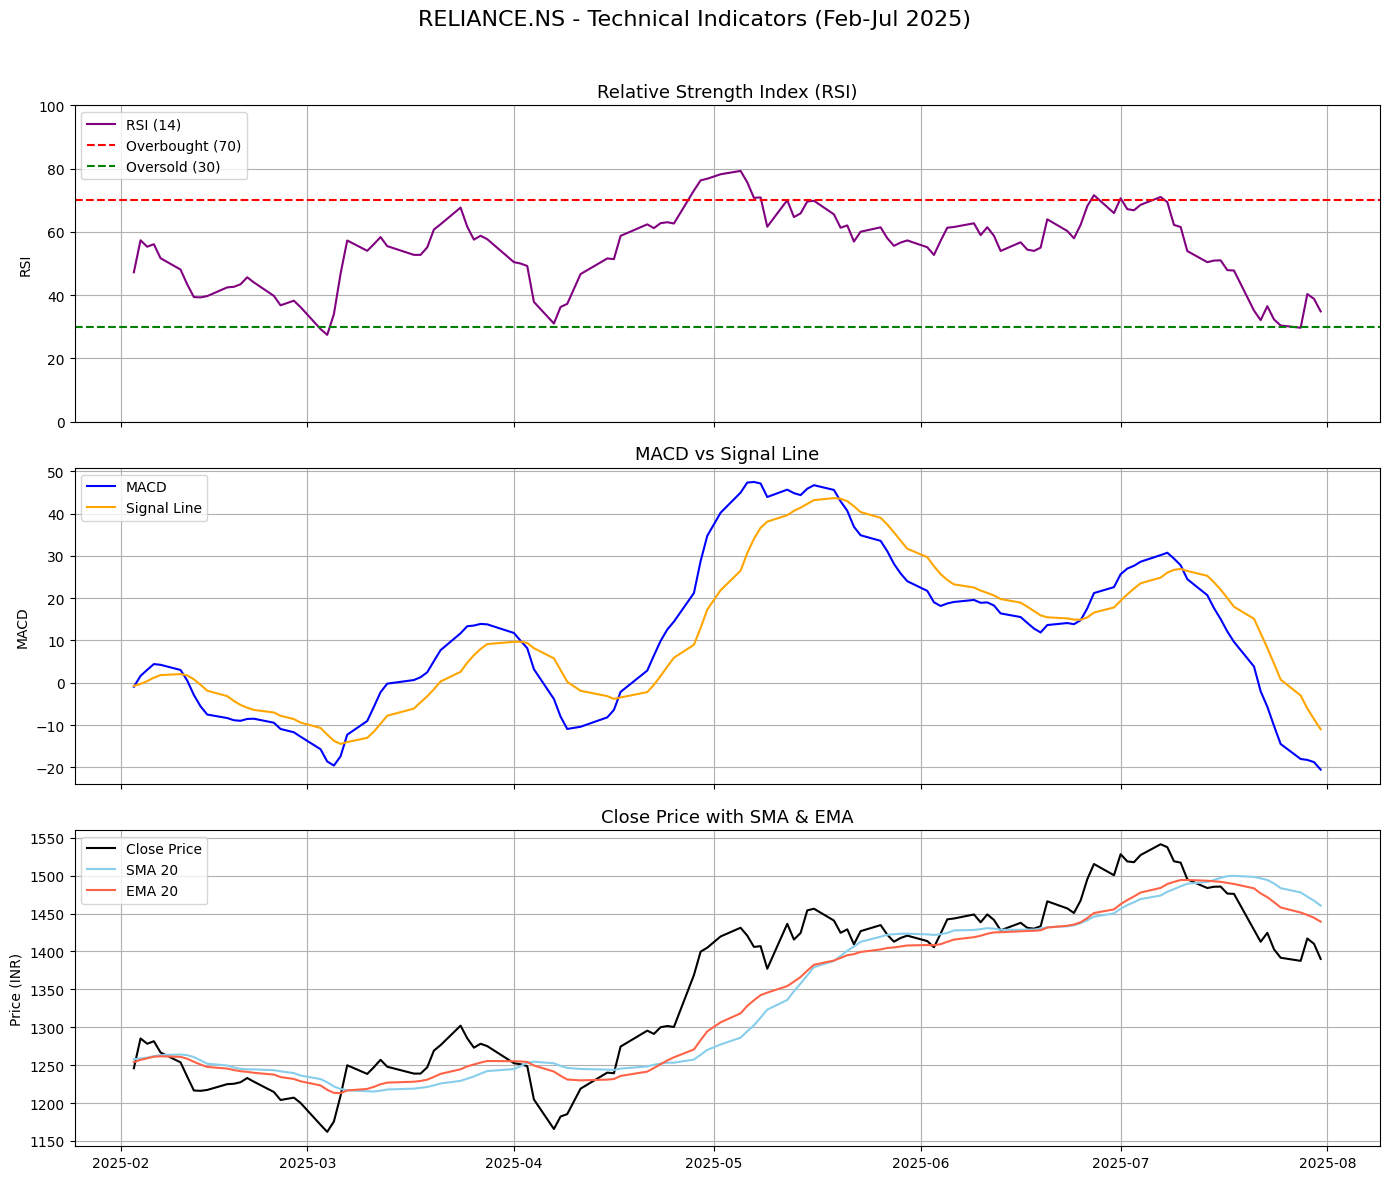


Plotting technical indicators for HDFCBANK.NS (122 data points)


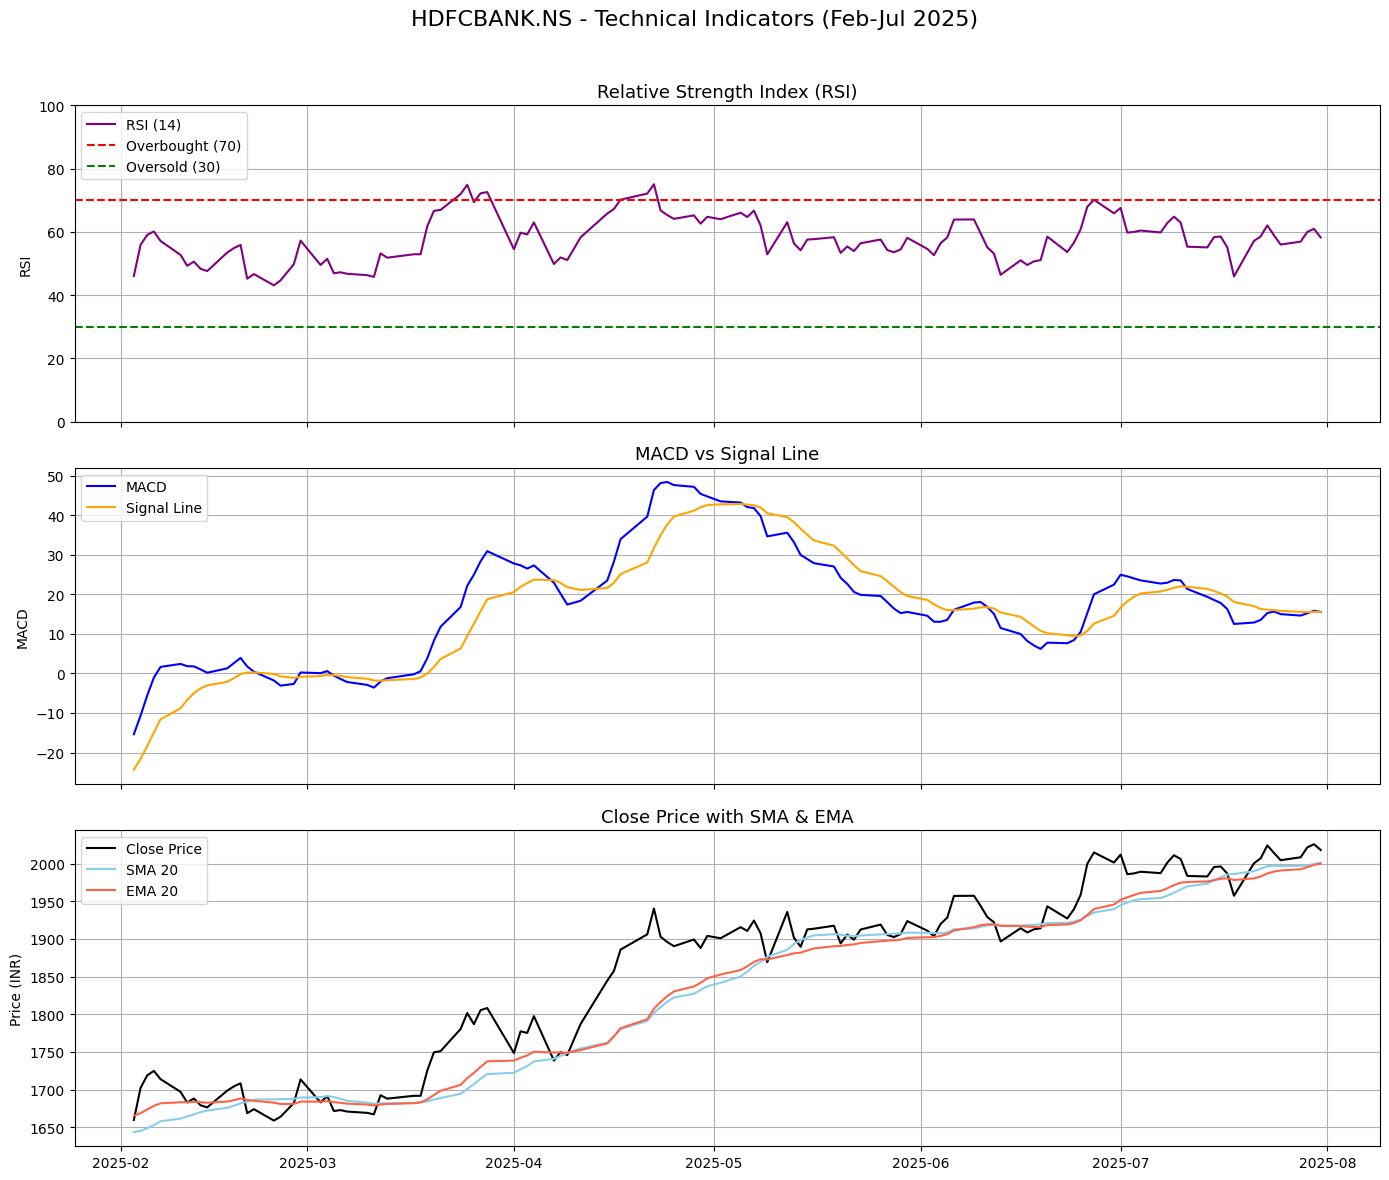

In [345]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Define symbols and backtest period (timezone-aware)
symbols = ["INFY.NS", "RELIANCE.NS", "HDFCBANK.NS"]
backtest_start = pd.to_datetime("2025-02-01", utc=True).tz_convert("Asia/Kolkata")
backtest_end = pd.to_datetime("2025-07-31", utc=True).tz_convert("Asia/Kolkata")

# Dictionary to access processed DataFrames
processed_data_dict = {
    "INFY.NS": processed_infy,
    "RELIANCE.NS": processed_reliance,
    "HDFCBANK.NS": processed_hdfcbank
}

# Visualization function
def plot_technical_indicators(symbol, data):
    # Filter data for backtest period
    data = data[(data.index >= backtest_start) & (data.index <= backtest_end)].copy()
    
    if data.empty:
        print(f"Error: No data available for {symbol} in backtest period (Feb-Jul 2025).")
        return
    
    print(f"\nPlotting technical indicators for {symbol} ({len(data)} data points)")
    
    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    fig.suptitle(f'{symbol} - Technical Indicators (Feb-Jul 2025)', fontsize=16)
    
    # RSI
    axes[0].plot(data.index, data['RSI'], label='RSI (14)', color='purple')
    axes[0].axhline(70, color='red', linestyle='--', label='Overbought (70)')
    axes[0].axhline(30, color='green', linestyle='--', label='Oversold (30)')
    axes[0].set_ylim(0, 100)
    axes[0].set_ylabel('RSI')
    axes[0].set_title('Relative Strength Index (RSI)', fontsize=13)
    axes[0].legend(loc='upper left')
    axes[0].grid(True)
    
    # MACD
    axes[1].plot(data.index, data['MACD'], label='MACD', color='blue')
    axes[1].plot(data.index, data['MACD_Signal'], label='Signal Line', color='orange')
    axes[1].set_ylabel('MACD')
    axes[1].set_title('MACD vs Signal Line', fontsize=13)
    axes[1].legend(loc='upper left')
    axes[1].grid(True)
    
    # Close + SMA + EMA
    axes[2].plot(data.index, data['Close'], label='Close Price', color='black')
    axes[2].plot(data.index, data['SMA_20'], label='SMA 20', color='skyblue')
    axes[2].plot(data.index, data['EMA_20'], label='EMA 20', color='tomato')
    axes[2].set_ylabel('Price (INR)')
    axes[2].set_title('Close Price with SMA & EMA', fontsize=13)
    axes[2].legend(loc='upper left')
    axes[2].grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Plot for each stock
for symbol in symbols:
    if symbol in processed_data_dict and processed_data_dict[symbol] is not None:
        plot_technical_indicators(symbol, processed_data_dict[symbol])
    else:
        print(f"Error: Processed data for {symbol} not found.")

## MODEL TRAINING AND BACKTESTING

### INFY.NS


=== Analysis for INFY.NS ===
Data from 2020-10-12 00:00:00+05:30 to 2025-08-01 00:00:00+05:30
Index timezone: Asia/Kolkata
Train data points: 1068, Test data points: 122


/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:06:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:06:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:06:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:06:05] WARNING

Best Parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50}

=== ML Model Performance ===
Accuracy: 48.36%
Precision: 48.98%
Recall: 78.69%
F1-Score: 60.38%

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.18      0.26        61
           1       0.49      0.79      0.60        61

    accuracy                           0.48       122
   macro avg       0.47      0.48      0.43       122
weighted avg       0.47      0.48      0.43       122



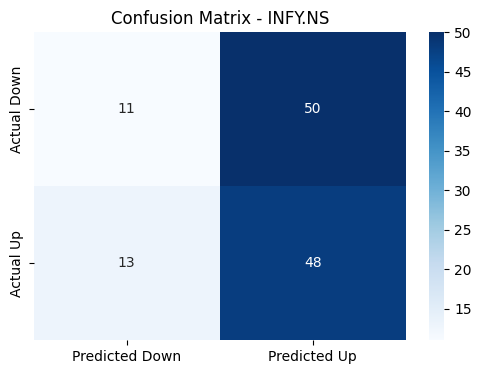


=== ML Trading Performance ===
Total Trades: 97
Profitable Trades: 45
Win Ratio: 46.39%
Avg Profit: 0.89%
Avg Loss: -1.31%
Cumulative Return: -25.19%


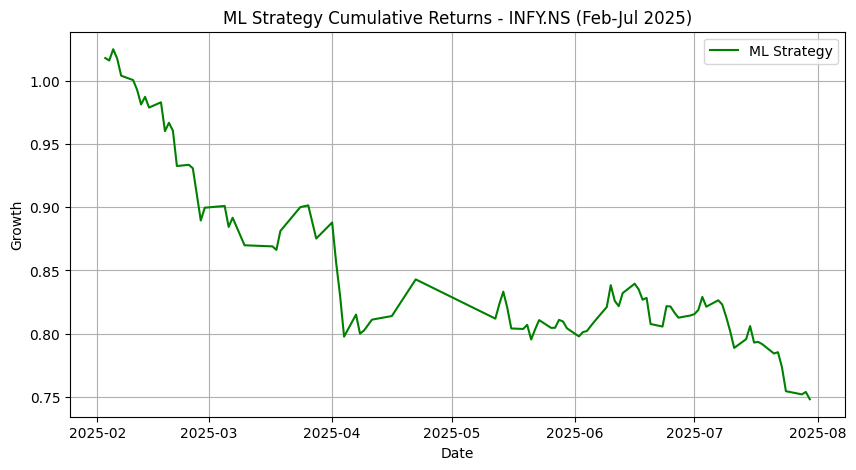


=== Rule-Based Strategy Performance ===
Total Trades: 2
Profitable Trades: 0
Win Ratio: 0.00%
Avg Profit: 0.00%
Avg Loss: -0.17%
Cumulative Return: -0.33%


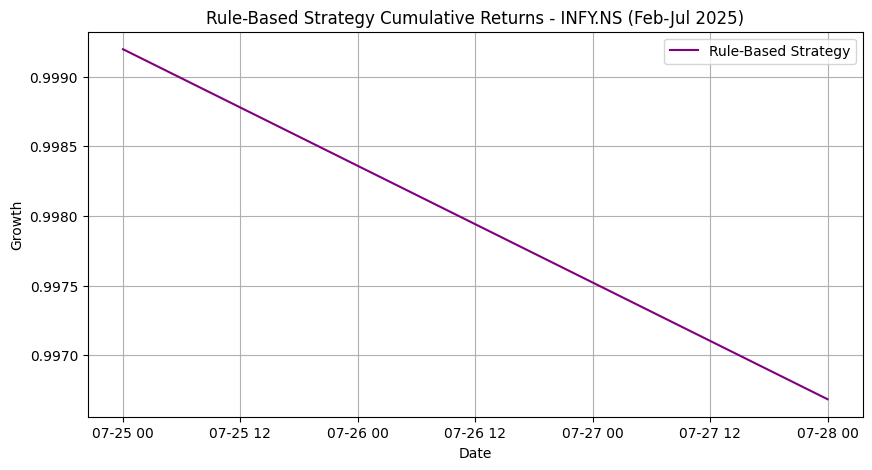


=== Agreement Trade Details ===
Total Agreement Trades: 2
Profitable Trades: 0
Win Ratio: 0.00%
Avg Return: -0.17%


In [ ]:
# Define backtest period (timezone-aware)
backtest_start = pd.to_datetime("2025-02-01", utc=True).tz_convert("Asia/Kolkata")
backtest_end = pd.to_datetime("2025-07-31", utc=True).tz_convert("Asia/Kolkata")

# Analysis function for INFY.NS
def run_analysis_infy(processed_data):
    symbol = "INFY.NS"
    print(f"\n=== Analysis for {symbol} ===")
    
    # Verify date range
    print(f"Data from {processed_data.index.min()} to {processed_data.index.max()}")
    print(f"Index timezone: {processed_data.index.tz}")
    
    # Features and target
    features = ["RSI", "MACD", "MACD_Signal", "SMA_20", "EMA_20", "Volatility"]
    X = processed_data[features]
    y = processed_data["Target"]
    
    # Split data: train (before Feb 2025), test (Feb 2025 - Jul 2025)
    train = processed_data[processed_data.index < backtest_start]
    test = processed_data[(processed_data.index >= backtest_start) & (processed_data.index <= backtest_end)]
    
    if len(test) == 0:
        print(f"Error: No data available for {symbol} in backtest period.")
        return None
    
    print(f"Train data points: {len(train)}, Test data points: {len(test)}")
    
    # Train XGBoost model
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [2, 3, 4],
        'learning_rate': [0.01, 0.1, 0.2],
    }
    grid = GridSearchCV(
        estimator=XGBClassifier(random_state=42, class_weight='balanced'),
        param_grid=param_grid,
        scoring='precision',
        cv=TimeSeriesSplit(n_splits=5),
        verbose=0,
        n_jobs=-1
    )
    grid.fit(train[features], train["Target"])
    best_model = grid.best_estimator_
    print("Best Parameters:", grid.best_params_)
    
    # Backtest: ML Strategy
    X_test = test[features]
    y_test = test["Target"]
    y_pred = best_model.predict(X_test)
    
    # Model performance
    print("\n=== ML Model Performance ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
    print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.2%}")
    print(f"Recall: {recall_score(y_test, y_pred, zero_division=0):.2%}")
    print(f"F1-Score: {f1_score(y_test, y_pred, zero_division=0):.2%}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Down', 'Predicted Up'],
                yticklabels=['Actual Down', 'Actual Up'])
    plt.title(f"Confusion Matrix - {symbol}")
    plt.show()
    
    # Simulate ML trades
    backtest_df = test.copy()
    backtest_df["ML_Prediction"] = y_pred
    backtest_df["Buy_Price"] = backtest_df["Close"].where(backtest_df["ML_Prediction"] == 1)
    backtest_df["Sell_Price"] = backtest_df["Close"].shift(-1).where(backtest_df["ML_Prediction"] == 1)
    backtest_df["Trade_Return"] = ((backtest_df["Sell_Price"] - backtest_df["Buy_Price"]) / 
                                   backtest_df["Buy_Price"] - 0.001)  # 0.1% transaction cost
    backtest_df = backtest_df.dropna(subset=["Trade_Return"])
    
    # ML trading metrics
    total_trades_ml = len(backtest_df)
    profitable_trades_ml = (backtest_df["Trade_Return"] > 0).sum()
    win_ratio_ml = profitable_trades_ml / total_trades_ml if total_trades_ml > 0 else 0
    avg_profit_ml = backtest_df[backtest_df["Trade_Return"] > 0]["Trade_Return"].mean() if profitable_trades_ml > 0 else 0
    avg_loss_ml = backtest_df[backtest_df["Trade_Return"] <= 0]["Trade_Return"].mean() if (total_trades_ml - profitable_trades_ml) > 0 else 0
    cumulative_return_ml = (1 + backtest_df["Trade_Return"]).prod() - 1
    
    print("\n=== ML Trading Performance ===")
    print(f"Total Trades: {total_trades_ml}")
    print(f"Profitable Trades: {profitable_trades_ml}")
    print(f"Win Ratio: {win_ratio_ml:.2%}")
    print(f"Avg Profit: {avg_profit_ml:.2%}")
    print(f"Avg Loss: {avg_loss_ml:.2%}")
    print(f"Cumulative Return: {cumulative_return_ml:.2%}")
    
    # Plot ML cumulative returns
    plt.figure(figsize=(10, 5))
    plt.plot(backtest_df.index, (1 + backtest_df["Trade_Return"]).cumprod(),
             label="ML Strategy", color="green")
    plt.title(f"ML Strategy Cumulative Returns - {symbol} (Feb-Jul 2025)")
    plt.xlabel("Date")
    plt.ylabel("Growth")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Simulate Rule-Based Strategy
    strategy_signals = test[test["Buy_Signal"] == 1].copy()
    strategy_signals["Trade_Return"] = ((strategy_signals["Close"].shift(-1) - 
                                        strategy_signals["Close"]) / 
                                       strategy_signals["Close"] - 0.001)
    strategy_signals = strategy_signals.dropna(subset=["Trade_Return"])
    
    total_trades_rule = len(strategy_signals)
    profitable_trades_rule = (strategy_signals["Trade_Return"] > 0).sum()
    win_ratio_rule = profitable_trades_rule / total_trades_rule if total_trades_rule > 0 else 0
    avg_profit_rule = strategy_signals[strategy_signals["Trade_Return"] > 0]["Trade_Return"].mean() if profitable_trades_rule > 0 else 0
    avg_loss_rule = strategy_signals[strategy_signals["Trade_Return"] <= 0]["Trade_Return"].mean() if (total_trades_rule - profitable_trades_rule) > 0 else 0
    cumulative_return_rule = (1 + strategy_signals["Trade_Return"]).prod() - 1
    
    print("\n=== Rule-Based Strategy Performance ===")
    print(f"Total Trades: {total_trades_rule}")
    print(f"Profitable Trades: {profitable_trades_rule}")
    print(f"Win Ratio: {win_ratio_rule:.2%}")
    print(f"Avg Profit: {avg_profit_rule:.2%}")
    print(f"Avg Loss: {avg_loss_rule:.2%}")
    print(f"Cumulative Return: {cumulative_return_rule:.2%}")
    
    # Plot rule-based cumulative returns
    plt.figure(figsize=(10, 5))
    plt.plot(strategy_signals.index, (1 + strategy_signals["Trade_Return"]).cumprod(),
             label="Rule-Based Strategy", color="purple")
    plt.title(f"Rule-Based Strategy Cumulative Returns - {symbol} (Feb-Jul 2025)")
    plt.xlabel("Date")
    plt.ylabel("Growth")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Agreement Analysis
    df_agreed = backtest_df[(backtest_df["ML_Prediction"] == 1) & (backtest_df["Buy_Signal"] == 1)].copy()
    df_agreed["Trade_Return"] = ((df_agreed["Close"].shift(-1) - df_agreed["Close"]) / 
                                 df_agreed["Close"] - 0.001)
    df_agreed = df_agreed.dropna(subset=["Trade_Return"])
    
    total_agreed = len(df_agreed)
    profitable_agreed = (df_agreed["Trade_Return"] > 0).sum()
    win_ratio_agreed = profitable_agreed / total_agreed if total_agreed > 0 else 0
    avg_return_agreed = df_agreed["Trade_Return"].mean() if total_agreed > 0 else 0
    
    print("\n=== Agreement Trade Details ===")
    print(f"Total Agreement Trades: {total_agreed}")
    print(f"Profitable Trades: {profitable_agreed}")
    print(f"Win Ratio: {win_ratio_agreed:.2%}")
    print(f"Avg Return: {avg_return_agreed:.2%}")
    
    return best_model

# Run analysis for INFY.NS
if processed_infy is not None:
    infy_model = run_analysis_infy(processed_infy)
    if infy_model is not None:
        infy_model.save_model("INFY_model.json")
else:
    print("Error: Processed data for INFY.NS not found.")

### RELIANCE.NS


=== Analysis for RELIANCE.NS ===
Data from 2020-10-12 00:00:00+05:30 to 2025-08-01 00:00:00+05:30
Index timezone: Asia/Kolkata
Train data points: 1068, Test data points: 122


/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:07:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:07:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:07:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:07:18] WARNING

Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}

=== ML Model Performance ===
Accuracy: 50.82%
Precision: 50.00%
Recall: 43.33%
F1-Score: 46.43%

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.58      0.55        62
           1       0.50      0.43      0.46        60

    accuracy                           0.51       122
   macro avg       0.51      0.51      0.50       122
weighted avg       0.51      0.51      0.51       122



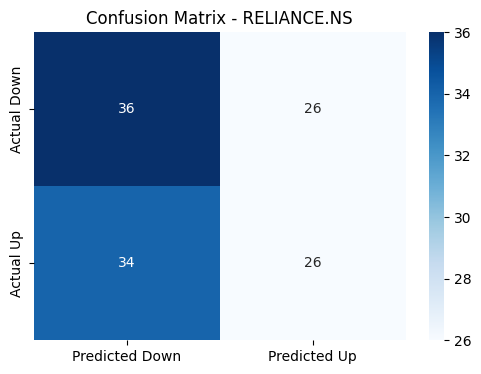


=== ML Trading Performance ===
Total Trades: 51
Profitable Trades: 24
Win Ratio: 47.06%
Avg Profit: 1.42%
Avg Loss: -0.89%
Cumulative Return: 9.93%


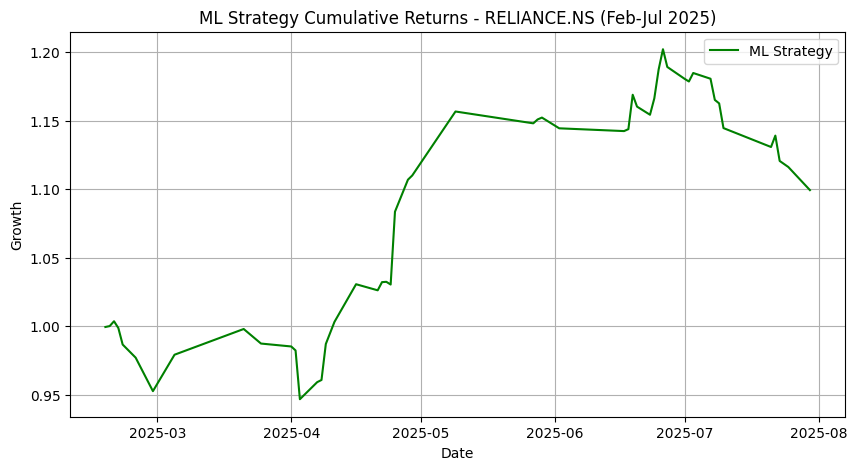


=== Rule-Based Strategy Performance ===
Total Trades: 5
Profitable Trades: 2
Win Ratio: 40.00%
Avg Profit: 10.59%
Avg Loss: -0.70%
Cumulative Return: 18.68%


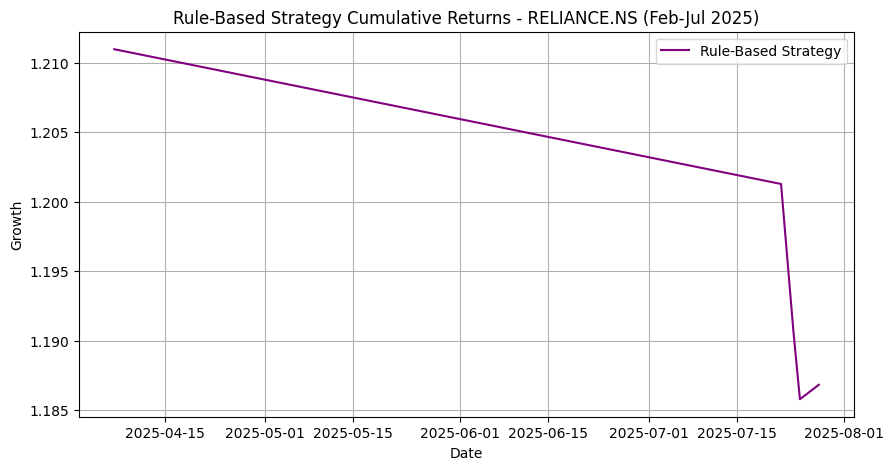


=== Agreement Trade Details ===
Total Agreement Trades: 2
Profitable Trades: 1
Win Ratio: 50.00%
Avg Return: 9.75%


In [348]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Define backtest period (timezone-aware)
backtest_start = pd.to_datetime("2025-02-01", utc=True).tz_convert("Asia/Kolkata")
backtest_end = pd.to_datetime("2025-07-31", utc=True).tz_convert("Asia/Kolkata")

# Analysis function for RELIANCE.NS
def run_analysis_reliance(processed_data):
    symbol = "RELIANCE.NS"
    print(f"\n=== Analysis for {symbol} ===")
    
    # Verify date range
    print(f"Data from {processed_data.index.min()} to {processed_data.index.max()}")
    print(f"Index timezone: {processed_data.index.tz}")
    
    # Features and target
    features = ["RSI", "MACD", "MACD_Signal", "SMA_20", "EMA_20", "Volatility"]
    X = processed_data[features]
    y = processed_data["Target"]
    
    # Split data: train (before Feb 2025), test (Feb 2025 - Jul 2025)
    train = processed_data[processed_data.index < backtest_start]
    test = processed_data[(processed_data.index >= backtest_start) & (processed_data.index <= backtest_end)]
    
    if len(test) == 0:
        print(f"Error: No data available for {symbol} in backtest period.")
        return None
    
    print(f"Train data points: {len(train)}, Test data points: {len(test)}")
    
    # Train XGBoost model
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [2, 3, 4],
        'learning_rate': [0.01, 0.1, 0.2],
    }
    grid = GridSearchCV(
        estimator=XGBClassifier(random_state=42, class_weight='balanced'),
        param_grid=param_grid,
        scoring='precision',
        cv=TimeSeriesSplit(n_splits=5),
        verbose=0,
        n_jobs=-1
    )
    grid.fit(train[features], train["Target"])
    best_model = grid.best_estimator_
    print("Best Parameters:", grid.best_params_)
    
    # Backtest: ML Strategy
    X_test = test[features]
    y_test = test["Target"]
    y_pred = best_model.predict(X_test)
    
    # Model performance
    print("\n=== ML Model Performance ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
    print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.2%}")
    print(f"Recall: {recall_score(y_test, y_pred, zero_division=0):.2%}")
    print(f"F1-Score: {f1_score(y_test, y_pred, zero_division=0):.2%}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Down', 'Predicted Up'],
                yticklabels=['Actual Down', 'Actual Up'])
    plt.title(f"Confusion Matrix - {symbol}")
    plt.show()
    
    # Simulate ML trades
    backtest_df = test.copy()
    backtest_df["ML_Prediction"] = y_pred
    backtest_df["Buy_Price"] = backtest_df["Close"].where(backtest_df["ML_Prediction"] == 1)
    backtest_df["Sell_Price"] = backtest_df["Close"].shift(-1).where(backtest_df["ML_Prediction"] == 1)
    backtest_df["Trade_Return"] = ((backtest_df["Sell_Price"] - backtest_df["Buy_Price"]) / 
                                   backtest_df["Buy_Price"] - 0.001)  # 0.1% transaction cost
    backtest_df = backtest_df.dropna(subset=["Trade_Return"])
    
    # ML trading metrics
    total_trades_ml = len(backtest_df)
    profitable_trades_ml = (backtest_df["Trade_Return"] > 0).sum()
    win_ratio_ml = profitable_trades_ml / total_trades_ml if total_trades_ml > 0 else 0
    avg_profit_ml = backtest_df[backtest_df["Trade_Return"] > 0]["Trade_Return"].mean() if profitable_trades_ml > 0 else 0
    avg_loss_ml = backtest_df[backtest_df["Trade_Return"] <= 0]["Trade_Return"].mean() if (total_trades_ml - profitable_trades_ml) > 0 else 0
    cumulative_return_ml = (1 + backtest_df["Trade_Return"]).prod() - 1
    
    print("\n=== ML Trading Performance ===")
    print(f"Total Trades: {total_trades_ml}")
    print(f"Profitable Trades: {profitable_trades_ml}")
    print(f"Win Ratio: {win_ratio_ml:.2%}")
    print(f"Avg Profit: {avg_profit_ml:.2%}")
    print(f"Avg Loss: {avg_loss_ml:.2%}")
    print(f"Cumulative Return: {cumulative_return_ml:.2%}")
    
    # Plot ML cumulative returns
    plt.figure(figsize=(10, 5))
    plt.plot(backtest_df.index, (1 + backtest_df["Trade_Return"]).cumprod(),
             label="ML Strategy", color="green")
    plt.title(f"ML Strategy Cumulative Returns - {symbol} (Feb-Jul 2025)")
    plt.xlabel("Date")
    plt.ylabel("Growth")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Simulate Rule-Based Strategy
    strategy_signals = test[test["Buy_Signal"] == 1].copy()
    strategy_signals["Trade_Return"] = ((strategy_signals["Close"].shift(-1) - 
                                        strategy_signals["Close"]) / 
                                       strategy_signals["Close"] - 0.001)
    strategy_signals = strategy_signals.dropna(subset=["Trade_Return"])
    
    total_trades_rule = len(strategy_signals)
    profitable_trades_rule = (strategy_signals["Trade_Return"] > 0).sum()
    win_ratio_rule = profitable_trades_rule / total_trades_rule if total_trades_rule > 0 else 0
    avg_profit_rule = strategy_signals[strategy_signals["Trade_Return"] > 0]["Trade_Return"].mean() if profitable_trades_rule > 0 else 0
    avg_loss_rule = strategy_signals[strategy_signals["Trade_Return"] <= 0]["Trade_Return"].mean() if (total_trades_rule - profitable_trades_rule) > 0 else 0
    cumulative_return_rule = (1 + strategy_signals["Trade_Return"]).prod() - 1
    
    print("\n=== Rule-Based Strategy Performance ===")
    print(f"Total Trades: {total_trades_rule}")
    print(f"Profitable Trades: {profitable_trades_rule}")
    print(f"Win Ratio: {win_ratio_rule:.2%}")
    print(f"Avg Profit: {avg_profit_rule:.2%}")
    print(f"Avg Loss: {avg_loss_rule:.2%}")
    print(f"Cumulative Return: {cumulative_return_rule:.2%}")
    
    # Plot rule-based cumulative returns
    plt.figure(figsize=(10, 5))
    plt.plot(strategy_signals.index, (1 + strategy_signals["Trade_Return"]).cumprod(),
             label="Rule-Based Strategy", color="purple")
    plt.title(f"Rule-Based Strategy Cumulative Returns - {symbol} (Feb-Jul 2025)")
    plt.xlabel("Date")
    plt.ylabel("Growth")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Agreement Analysis
    df_agreed = backtest_df[(backtest_df["ML_Prediction"] == 1) & (backtest_df["Buy_Signal"] == 1)].copy()
    df_agreed["Trade_Return"] = ((df_agreed["Close"].shift(-1) - df_agreed["Close"]) / 
                                 df_agreed["Close"] - 0.001)
    df_agreed = df_agreed.dropna(subset=["Trade_Return"])
    
    total_agreed = len(df_agreed)
    profitable_agreed = (df_agreed["Trade_Return"] > 0).sum()
    win_ratio_agreed = profitable_agreed / total_agreed if total_agreed > 0 else 0
    avg_return_agreed = df_agreed["Trade_Return"].mean() if total_agreed > 0 else 0
    
    print("\n=== Agreement Trade Details ===")
    print(f"Total Agreement Trades: {total_agreed}")
    print(f"Profitable Trades: {profitable_agreed}")
    print(f"Win Ratio: {win_ratio_agreed:.2%}")
    print(f"Avg Return: {avg_return_agreed:.2%}")
    
    return best_model

# Run analysis for RELIANCE.NS
if processed_reliance is not None:
    reliance_model = run_analysis_reliance(processed_reliance)
    if reliance_model is not None:
        reliance_model.save_model("RELIANCE_model.json")
else:
    print("Error: Processed data for RELIANCE.NS not found.")

### HDFCBANK.NS


=== Analysis for HDFCBANK.NS ===
Data from 2020-10-12 00:00:00+05:30 to 2025-08-01 00:00:00+05:30
Index timezone: Asia/Kolkata
Train data points: 1068, Test data points: 122


/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:08:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:08:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:08:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [11:08:32] WARNING

Best Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 150}

=== ML Model Performance ===
Accuracy: 45.90%
Precision: 55.56%
Recall: 21.74%
F1-Score: 31.25%

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.77      0.55        53
           1       0.56      0.22      0.31        69

    accuracy                           0.46       122
   macro avg       0.49      0.50      0.43       122
weighted avg       0.50      0.46      0.42       122



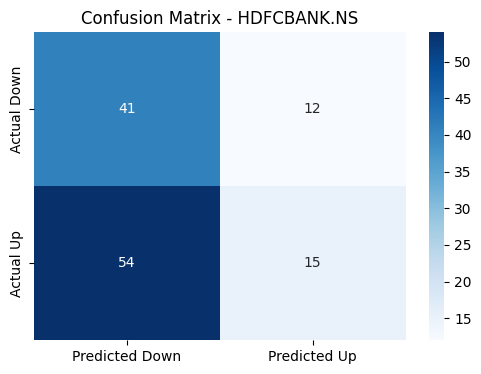


=== ML Trading Performance ===
Total Trades: 27
Profitable Trades: 13
Win Ratio: 48.15%
Avg Profit: 1.22%
Avg Loss: -1.04%
Cumulative Return: 1.01%


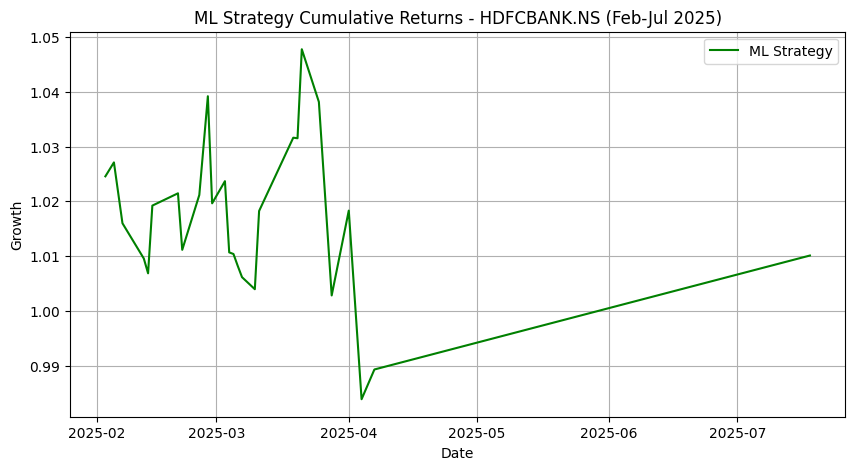


=== Rule-Based Strategy Performance ===
Total Trades: 0
Profitable Trades: 0
Win Ratio: 0.00%
Avg Profit: 0.00%
Avg Loss: 0.00%
Cumulative Return: 0.00%


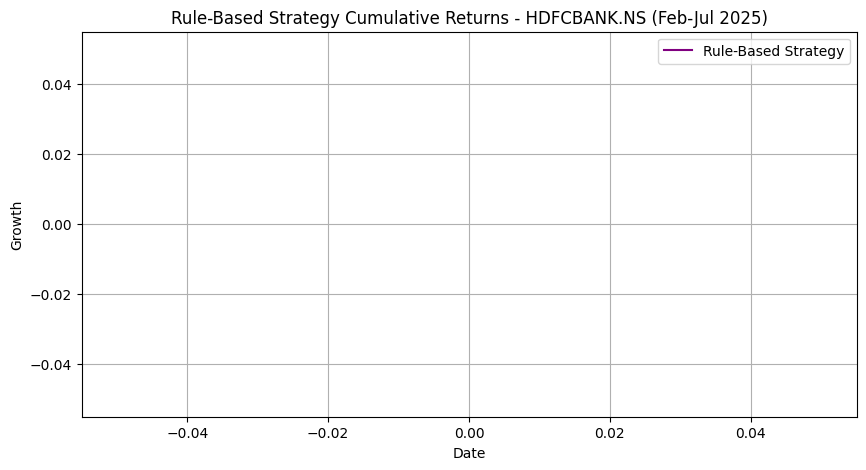


=== Agreement Trade Details ===
Total Agreement Trades: 0
Profitable Trades: 0
Win Ratio: 0.00%
Avg Return: 0.00%


In [349]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Define backtest period (timezone-aware)
backtest_start = pd.to_datetime("2025-02-01", utc=True).tz_convert("Asia/Kolkata")
backtest_end = pd.to_datetime("2025-07-31", utc=True).tz_convert("Asia/Kolkata")

# Analysis function for HDFCBANK.NS
def run_analysis_hdfcbank(processed_data):
    symbol = "HDFCBANK.NS"
    print(f"\n=== Analysis for {symbol} ===")
    
    # Verify date range
    print(f"Data from {processed_data.index.min()} to {processed_data.index.max()}")
    print(f"Index timezone: {processed_data.index.tz}")
    
    # Features and target
    features = ["RSI", "MACD", "MACD_Signal", "SMA_20", "EMA_20", "Volatility"]
    X = processed_data[features]
    y = processed_data["Target"]
    
    # Split data: train (before Feb 2025), test (Feb 2025 - Jul 2025)
    train = processed_data[processed_data.index < backtest_start]
    test = processed_data[(processed_data.index >= backtest_start) & (processed_data.index <= backtest_end)]
    
    if len(test) == 0:
        print(f"Error: No data available for {symbol} in backtest period.")
        return None
    
    print(f"Train data points: {len(train)}, Test data points: {len(test)}")
    
    # Train XGBoost model
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [2, 3, 4],
        'learning_rate': [0.01, 0.1, 0.2],
    }
    grid = GridSearchCV(
        estimator=XGBClassifier(random_state=42, class_weight='balanced'),
        param_grid=param_grid,
        scoring='precision',
        cv=TimeSeriesSplit(n_splits=5),
        verbose=0,
        n_jobs=-1
    )
    grid.fit(train[features], train["Target"])
    best_model = grid.best_estimator_
    print("Best Parameters:", grid.best_params_)
    
    # Backtest: ML Strategy
    X_test = test[features]
    y_test = test["Target"]
    y_pred = best_model.predict(X_test)
    
    # Model performance
    print("\n=== ML Model Performance ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
    print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.2%}")
    print(f"Recall: {recall_score(y_test, y_pred, zero_division=0):.2%}")
    print(f"F1-Score: {f1_score(y_test, y_pred, zero_division=0):.2%}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Down', 'Predicted Up'],
                yticklabels=['Actual Down', 'Actual Up'])
    plt.title(f"Confusion Matrix - {symbol}")
    plt.show()
    
    # Simulate ML trades
    backtest_df = test.copy()
    backtest_df["ML_Prediction"] = y_pred
    backtest_df["Buy_Price"] = backtest_df["Close"].where(backtest_df["ML_Prediction"] == 1)
    backtest_df["Sell_Price"] = backtest_df["Close"].shift(-1).where(backtest_df["ML_Prediction"] == 1)
    backtest_df["Trade_Return"] = ((backtest_df["Sell_Price"] - backtest_df["Buy_Price"]) / 
                                   backtest_df["Buy_Price"] - 0.001)  # 0.1% transaction cost
    backtest_df = backtest_df.dropna(subset=["Trade_Return"])
    
    # ML trading metrics
    total_trades_ml = len(backtest_df)
    profitable_trades_ml = (backtest_df["Trade_Return"] > 0).sum()
    win_ratio_ml = profitable_trades_ml / total_trades_ml if total_trades_ml > 0 else 0
    avg_profit_ml = backtest_df[backtest_df["Trade_Return"] > 0]["Trade_Return"].mean() if profitable_trades_ml > 0 else 0
    avg_loss_ml = backtest_df[backtest_df["Trade_Return"] <= 0]["Trade_Return"].mean() if (total_trades_ml - profitable_trades_ml) > 0 else 0
    cumulative_return_ml = (1 + backtest_df["Trade_Return"]).prod() - 1
    
    print("\n=== ML Trading Performance ===")
    print(f"Total Trades: {total_trades_ml}")
    print(f"Profitable Trades: {profitable_trades_ml}")
    print(f"Win Ratio: {win_ratio_ml:.2%}")
    print(f"Avg Profit: {avg_profit_ml:.2%}")
    print(f"Avg Loss: {avg_loss_ml:.2%}")
    print(f"Cumulative Return: {cumulative_return_ml:.2%}")
    
    # Plot ML cumulative returns
    plt.figure(figsize=(10, 5))
    plt.plot(backtest_df.index, (1 + backtest_df["Trade_Return"]).cumprod(),
             label="ML Strategy", color="green")
    plt.title(f"ML Strategy Cumulative Returns - {symbol} (Feb-Jul 2025)")
    plt.xlabel("Date")
    plt.ylabel("Growth")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Simulate Rule-Based Strategy
    strategy_signals = test[test["Buy_Signal"] == 1].copy()
    strategy_signals["Trade_Return"] = ((strategy_signals["Close"].shift(-1) - 
                                        strategy_signals["Close"]) / 
                                       strategy_signals["Close"] - 0.001)
    strategy_signals = strategy_signals.dropna(subset=["Trade_Return"])
    
    total_trades_rule = len(strategy_signals)
    profitable_trades_rule = (strategy_signals["Trade_Return"] > 0).sum()
    win_ratio_rule = profitable_trades_rule / total_trades_rule if total_trades_rule > 0 else 0
    avg_profit_rule = strategy_signals[strategy_signals["Trade_Return"] > 0]["Trade_Return"].mean() if profitable_trades_rule > 0 else 0
    avg_loss_rule = strategy_signals[strategy_signals["Trade_Return"] <= 0]["Trade_Return"].mean() if (total_trades_rule - profitable_trades_rule) > 0 else 0
    cumulative_return_rule = (1 + strategy_signals["Trade_Return"]).prod() - 1
    
    print("\n=== Rule-Based Strategy Performance ===")
    print(f"Total Trades: {total_trades_rule}")
    print(f"Profitable Trades: {profitable_trades_rule}")
    print(f"Win Ratio: {win_ratio_rule:.2%}")
    print(f"Avg Profit: {avg_profit_rule:.2%}")
    print(f"Avg Loss: {avg_loss_rule:.2%}")
    print(f"Cumulative Return: {cumulative_return_rule:.2%}")
    
    # Plot rule-based cumulative returns
    plt.figure(figsize=(10, 5))
    plt.plot(strategy_signals.index, (1 + strategy_signals["Trade_Return"]).cumprod(),
             label="Rule-Based Strategy", color="purple")
    plt.title(f"Rule-Based Strategy Cumulative Returns - {symbol} (Feb-Jul 2025)")
    plt.xlabel("Date")
    plt.ylabel("Growth")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Agreement Analysis
    df_agreed = backtest_df[(backtest_df["ML_Prediction"] == 1) & (backtest_df["Buy_Signal"] == 1)].copy()
    df_agreed["Trade_Return"] = ((df_agreed["Close"].shift(-1) - df_agreed["Close"]) / 
                                 df_agreed["Close"] - 0.001)
    df_agreed = df_agreed.dropna(subset=["Trade_Return"])
    
    total_agreed = len(df_agreed)
    profitable_agreed = (df_agreed["Trade_Return"] > 0).sum()
    win_ratio_agreed = profitable_agreed / total_agreed if total_agreed > 0 else 0
    avg_return_agreed = df_agreed["Trade_Return"].mean() if total_agreed > 0 else 0
    
    print("\n=== Agreement Trade Details ===")
    print(f"Total Agreement Trades: {total_agreed}")
    print(f"Profitable Trades: {profitable_agreed}")
    print(f"Win Ratio: {win_ratio_agreed:.2%}")
    print(f"Avg Return: {avg_return_agreed:.2%}")
    
    return best_model

# Run analysis for HDFCBANK.NS
if processed_hdfcbank is not None:
    hdfcbank_model = run_analysis_hdfcbank(processed_hdfcbank)
    if hdfcbank_model is not None:
        hdfcbank_model.save_model("HDFCBANK_model.json")
else:
    print("Error: Processed data for HDFCBANK.NS not found.")

# Using Strategy ( Implement RSI < 30 as a buy signal and cnnfirm with 20-DMA crossing above 50-DMA)

## INFY.NS


📊 Strategy Performance (RSI + SMA)
🔍 Strategy triggered: 3 times in last 6 months
✅ Signal Accuracy: 0.67

💰 Strategy Metrics:
📊 Total Trades: 2
✅ Profitable Trades: 1
❌ Losing Trades: 1
🎯 Win Ratio: 0.5
📈 Avg Profit: 0.02%
📉 Avg Loss: -0.15%
💸 Cumulative Return: -0.13%


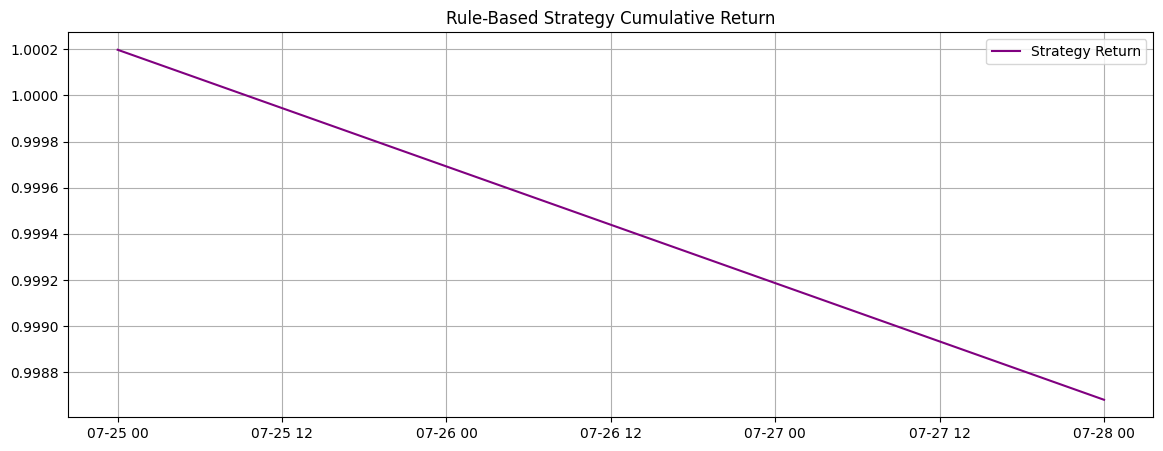

In [299]:
# 🧠 Section 3: Strategy Logic (RSI + SMA)

import yfinance as yf
import pandas as pd
import ta  # for technical indicators
import matplotlib.pyplot as plt

# --- Load Data ---
symbol = "INFY.NS"
df = yf.Ticker(symbol).history(period="5y")

# --- Indicators ---
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# --- Buy Signal ---
df['Buy_Signal'] = ((df['RSI'] < 35) & (df['SMA_20'] > df['SMA_50'])).astype(int)

# --- Target (same day or next day move) ---
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# --- Filter last 6 months ---
df_recent = df[df.index >= (df.index.max() - pd.DateOffset(months=6))]

# --- Evaluate Signal Accuracy ---
strategy_signals = df_recent[df_recent['Buy_Signal'] == 1]
correct_signals = (strategy_signals['Target'] == 1).sum()
strategy_accuracy = correct_signals / len(strategy_signals) if len(strategy_signals) > 0 else 0

# --- Print Accuracy ---
print("\n📊 Strategy Performance (RSI + SMA)")
print(f"🔍 Strategy triggered: {len(strategy_signals)} times in last 6 months")
print(f"✅ Signal Accuracy: {round(strategy_accuracy, 2)}")

# 💰 Section 4: Comparison & Metrics

# Simulate trade return
strategy_signals['Buy_Price'] = strategy_signals['Close']
strategy_signals['Sell_Price'] = strategy_signals['Close'].shift(-1)
strategy_signals['Trade_Return'] = (strategy_signals['Sell_Price'] - strategy_signals['Buy_Price']) / strategy_signals['Buy_Price']

# Drop NaNs
strategy_signals.dropna(inplace=True)

# Calculate metrics
total_trades = len(strategy_signals)
profitable_trades = (strategy_signals['Trade_Return'] > 0).sum()
losing_trades = (strategy_signals['Trade_Return'] <= 0).sum()
win_ratio = profitable_trades / total_trades if total_trades > 0 else 0
avg_profit = strategy_signals[strategy_signals['Trade_Return'] > 0]['Trade_Return'].mean()
avg_loss = strategy_signals[strategy_signals['Trade_Return'] <= 0]['Trade_Return'].mean()
cumulative_return = (1 + strategy_signals['Trade_Return']).prod() - 1


# Filter last 6 months
df_recent = processed_infy[processed_infy.index >= (processed_infy.index.max() - pd.DateOffset(months=6))].copy()

# Strategy condition: RSI < 35 and SMA20 crosses above SMA50
df_recent["Buy_Signal"] = (
    (df_recent["RSI"] < 35) &
    (df_recent["SMA_20"] > df_recent["SMA_50"]) &
    (df_recent["SMA_20"].shift(1) <= df_recent["SMA_50"].shift(1))
).astype(int)

# Simulate next-day return
df_recent["Trade_Return"] = df_recent["Close"].pct_change().shift(-1)

# Create filtered DataFrame for buy signals only
df_strategy_backtest = df_recent[df_recent["Buy_Signal"] == 1].copy()
df_strategy_backtest = df_strategy_backtest.dropna(subset=["Trade_Return"])

# --- Print Metrics ---
print("\n💰 Strategy Metrics:")
print(f"📊 Total Trades: {total_trades}")
print(f"✅ Profitable Trades: {profitable_trades}")
print(f"❌ Losing Trades: {losing_trades}")
print(f"🎯 Win Ratio: {round(win_ratio, 2)}")
print(f"📈 Avg Profit: {round(avg_profit * 100, 2)}%")
print(f"📉 Avg Loss: {round(avg_loss * 100, 2)}%")
print(f"💸 Cumulative Return: {round(cumulative_return * 100, 2)}%")

# Optional: Plot
plt.figure(figsize=(14, 5))
plt.plot((1 + strategy_signals['Trade_Return']).cumprod(), label="Strategy Return", color='purple')
plt.title("Rule-Based Strategy Cumulative Return")
plt.grid(True)
plt.legend()
plt.show()

## HDFCBANK.NS


📊 Strategy Performance (RSI + SMA)
🔍 Strategy triggered: 4 times in last 6 months
✅ Signal Accuracy: 0.5

💰 Strategy Metrics:
📊 Total Trades: 3
✅ Profitable Trades: 1
❌ Losing Trades: 2
🎯 Win Ratio: 0.33
📈 Avg Profit: 0.02%
📉 Avg Loss: -1.26%
💸 Cumulative Return: -2.5%


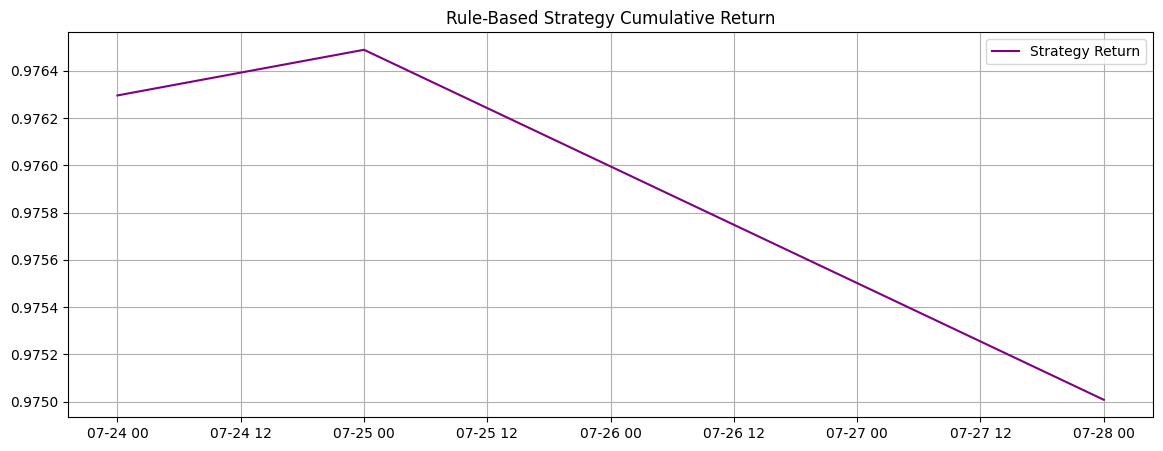

In [300]:
# 🧠 Section 3: Strategy Logic (RSI + SMA)

import yfinance as yf
import pandas as pd
import ta  # for technical indicators
import matplotlib.pyplot as plt

# --- Load Data ---
symbol = "INFY.NS"
df = yf.Ticker(symbol).history(period="5y")

# --- Indicators ---
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# --- Buy Signal ---
df['Buy_Signal'] = ((df['RSI'] < 40) & (df['SMA_20'] > df['SMA_50'])).astype(int)

# --- Target (same day or next day move) ---
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# --- Filter last 6 months ---
df_recent = df[df.index >= (df.index.max() - pd.DateOffset(months=6))]

# --- Evaluate Signal Accuracy ---
strategy_signals = df_recent[df_recent['Buy_Signal'] == 1]
correct_signals = (strategy_signals['Target'] == 1).sum()
strategy_accuracy = correct_signals / len(strategy_signals) if len(strategy_signals) > 0 else 0

# --- Print Accuracy ---
print("\n📊 Strategy Performance (RSI + SMA)")
print(f"🔍 Strategy triggered: {len(strategy_signals)} times in last 6 months")
print(f"✅ Signal Accuracy: {round(strategy_accuracy, 2)}")

# 💰 Section 4: Comparison & Metrics

# Simulate trade return
strategy_signals['Buy_Price'] = strategy_signals['Close']
strategy_signals['Sell_Price'] = strategy_signals['Close'].shift(-1)
strategy_signals['Trade_Return'] = (strategy_signals['Sell_Price'] - strategy_signals['Buy_Price']) / strategy_signals['Buy_Price']

# Drop NaNs
strategy_signals.dropna(inplace=True)

# Calculate metrics
total_trades = len(strategy_signals)
profitable_trades = (strategy_signals['Trade_Return'] > 0).sum()
losing_trades = (strategy_signals['Trade_Return'] <= 0).sum()
win_ratio = profitable_trades / total_trades if total_trades > 0 else 0
avg_profit = strategy_signals[strategy_signals['Trade_Return'] > 0]['Trade_Return'].mean()
avg_loss = strategy_signals[strategy_signals['Trade_Return'] <= 0]['Trade_Return'].mean()
cumulative_return = (1 + strategy_signals['Trade_Return']).prod() - 1


# Filter last 6 months
df_recent = processed_infy[processed_infy.index >= (processed_infy.index.max() - pd.DateOffset(months=6))].copy()

# Strategy condition: RSI < 35 and SMA20 crosses above SMA50
df_recent["Buy_Signal"] = (
    (df_recent["RSI"] < 40) &
    (df_recent["SMA_20"] > df_recent["SMA_50"]) &
    (df_recent["SMA_20"].shift(1) <= df_recent["SMA_50"].shift(1))
).astype(int)

# Simulate next-day return
df_recent["Trade_Return"] = df_recent["Close"].pct_change().shift(-1)

# Create filtered DataFrame for buy signals only
df_strategy_backtest = df_recent[df_recent["Buy_Signal"] == 1].copy()
df_strategy_backtest = df_strategy_backtest.dropna(subset=["Trade_Return"])

# --- Print Metrics ---
print("\n💰 Strategy Metrics:")
print(f"📊 Total Trades: {total_trades}")
print(f"✅ Profitable Trades: {profitable_trades}")
print(f"❌ Losing Trades: {losing_trades}")
print(f"🎯 Win Ratio: {round(win_ratio, 2)}")
print(f"📈 Avg Profit: {round(avg_profit * 100, 2)}%")
print(f"📉 Avg Loss: {round(avg_loss * 100, 2)}%")
print(f"💸 Cumulative Return: {round(cumulative_return * 100, 2)}%")

# Optional: Plot
plt.figure(figsize=(14, 5))
plt.plot((1 + strategy_signals['Trade_Return']).cumprod(), label="Strategy Return", color='purple')
plt.title("Rule-Based Strategy Cumulative Return")
plt.grid(True)
plt.legend()
plt.show()

## RELIANCE.NS


📊 Strategy Performance (RSI + SMA)
🔍 Strategy triggered: 6 times in last 6 months
✅ Signal Accuracy: 0.67

💰 Strategy Metrics:
📊 Total Trades: 5
✅ Profitable Trades: 2
❌ Losing Trades: 3
🎯 Win Ratio: 0.4
📈 Avg Profit: 10.69%
📉 Avg Loss: -0.6%
💸 Cumulative Return: 19.26%


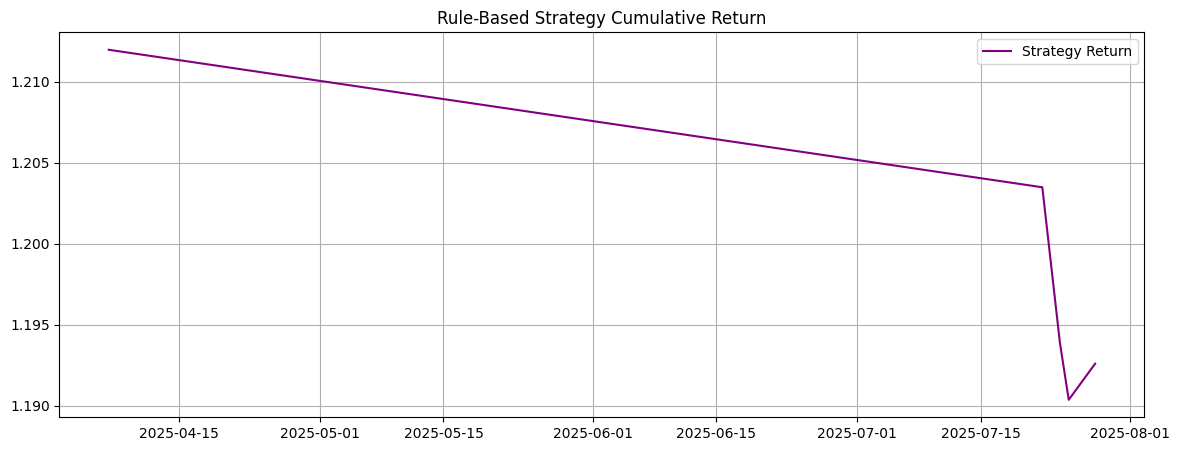

In [301]:
# 🧠 Section 3: Strategy Logic (RSI + SMA)

import yfinance as yf
import pandas as pd
import ta  # for technical indicators
import matplotlib.pyplot as plt

# --- Load Data ---
symbol = "RELIANCE.NS"
df = yf.Ticker(symbol).history(period="5y")

# --- Indicators ---
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# --- Buy Signal ---
df['Buy_Signal'] = ((df['RSI'] < 35) & (df['SMA_20'] > df['SMA_50'])).astype(int)

# --- Target (same day or next day move) ---
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# --- Filter last 6 months ---
df_recent = df[df.index >= (df.index.max() - pd.DateOffset(months=6))]

# --- Evaluate Signal Accuracy ---
strategy_signals = df_recent[df_recent['Buy_Signal'] == 1]
correct_signals = (strategy_signals['Target'] == 1).sum()
strategy_accuracy = correct_signals / len(strategy_signals) if len(strategy_signals) > 0 else 0

# --- Print Accuracy ---
print("\n📊 Strategy Performance (RSI + SMA)")
print(f"🔍 Strategy triggered: {len(strategy_signals)} times in last 6 months")
print(f"✅ Signal Accuracy: {round(strategy_accuracy, 2)}")

# 💰 Section 4: Comparison & Metrics

# Simulate trade return
strategy_signals['Buy_Price'] = strategy_signals['Close']
strategy_signals['Sell_Price'] = strategy_signals['Close'].shift(-1)
strategy_signals['Trade_Return'] = (strategy_signals['Sell_Price'] - strategy_signals['Buy_Price']) / strategy_signals['Buy_Price']

# Drop NaNs
strategy_signals.dropna(inplace=True)

# Calculate metrics
total_trades = len(strategy_signals)
profitable_trades = (strategy_signals['Trade_Return'] > 0).sum()
losing_trades = (strategy_signals['Trade_Return'] <= 0).sum()
win_ratio = profitable_trades / total_trades if total_trades > 0 else 0
avg_profit = strategy_signals[strategy_signals['Trade_Return'] > 0]['Trade_Return'].mean()
avg_loss = strategy_signals[strategy_signals['Trade_Return'] <= 0]['Trade_Return'].mean()
cumulative_return = (1 + strategy_signals['Trade_Return']).prod() - 1


# Filter last 6 months
df_recent = processed_infy[processed_infy.index >= (processed_infy.index.max() - pd.DateOffset(months=6))].copy()

# Strategy condition: RSI < 30 and SMA20 crosses above SMA50
df_recent["Buy_Signal"] = (
    (df_recent["RSI"] < 35) &
    (df_recent["SMA_20"] > df_recent["SMA_50"]) &
    (df_recent["SMA_20"].shift(1) <= df_recent["SMA_50"].shift(1))
).astype(int)

# Simulate next-day return
df_recent["Trade_Return"] = df_recent["Close"].pct_change().shift(-1)

# Create filtered DataFrame for buy signals only
df_strategy_backtest = df_recent[df_recent["Buy_Signal"] == 1].copy()
df_strategy_backtest = df_strategy_backtest.dropna(subset=["Trade_Return"])

# --- Print Metrics ---
print("\n💰 Strategy Metrics:")
print(f"📊 Total Trades: {total_trades}")
print(f"✅ Profitable Trades: {profitable_trades}")
print(f"❌ Losing Trades: {losing_trades}")
print(f"🎯 Win Ratio: {round(win_ratio, 2)}")
print(f"📈 Avg Profit: {round(avg_profit * 100, 2)}%")
print(f"📉 Avg Loss: {round(avg_loss * 100, 2)}%")
print(f"💸 Cumulative Return: {round(cumulative_return * 100, 2)}%")

# Optional: Plot
plt.figure(figsize=(14, 5))
plt.plot((1 + strategy_signals['Trade_Return']).cumprod(), label="Strategy Return", color='purple')
plt.title("Rule-Based Strategy Cumulative Return")
plt.grid(True)
plt.legend()
plt.show()

## RESULT AND COMPARISON

In [302]:
from datetime import timedelta

# Step 1: Last 6 months
last_6mo_mask = processed_reliance.index >= (processed_reliance.index.max() - pd.DateOffset(months=6))
df_recent = processed_reliance[last_6mo_mask].copy()

In [305]:
from sklearn.metrics import accuracy_score
import numpy as np

# Make predictions for last 6 months using trained model
X_recent = X.loc[df_recent.index]
df_recent["ML_Prediction"] = best_model.predict(X_recent)

# Compare: both strategies agree on the same day
agreed_trades = df_recent[
    (df_recent["Buy_Signal"] == 1) & (df_recent["ML_Prediction"] == 1)
].copy()

# Calculate returns for agreed trades
agreed_trades["Trade_Return"] = agreed_trades["Close"].pct_change().shift(-1)
agreed_trades = agreed_trades.dropna(subset=["Trade_Return"])

# Metrics
num_agreed = len(agreed_trades)
profitable = (agreed_trades["Trade_Return"] > 0).sum()
win_rate = profitable / num_agreed if num_agreed > 0 else 0
avg_return = agreed_trades["Trade_Return"].mean() if num_agreed > 0 else 0

# 📊 Print results
print(f"📅 RELIANCE (Last 6 Months) - Days Both Agreed: {num_agreed}")
print(f"✅ Win Rate: {round(win_rate * 100, 2)}%")
print(f"💰 Avg Return: {round(avg_return * 100, 2)}%")

📅 RELIANCE (Last 6 Months) - Days Both Agreed: 0
✅ Win Rate: 0%
💰 Avg Return: 0%


In [ ]:
both_agree = df_recent[
    (df_recent["ML_Prediction"] == 1) & (df_recent["Logic_Signal"] == 1)
].copy()

both_agree["Trade_Return"] = df_recent["Close"].pct_change().shift(-1)
both_agree.dropna(subset=["Trade_Return"], inplace=True)

agree_win_rate = (both_agree["Trade_Return"] > 0).mean()
agree_avg_return = both_agree["Trade_Return"].mean()

print(f"\n📅 RELIANCE (Last 6 Months) - Days Both Agreed: {len(both_agree)}")
print(f"✅ Win Rate: {round(agree_win_rate * 100, 2)}%")
print(f"💰 Avg Return: {round(agree_avg_return * 100, 2)}%")


📅 RELIANCE (Last 6 Months) - Days Both Agreed: 123
✅ Win Rate: 48.78%
💰 Avg Return: 0.09%


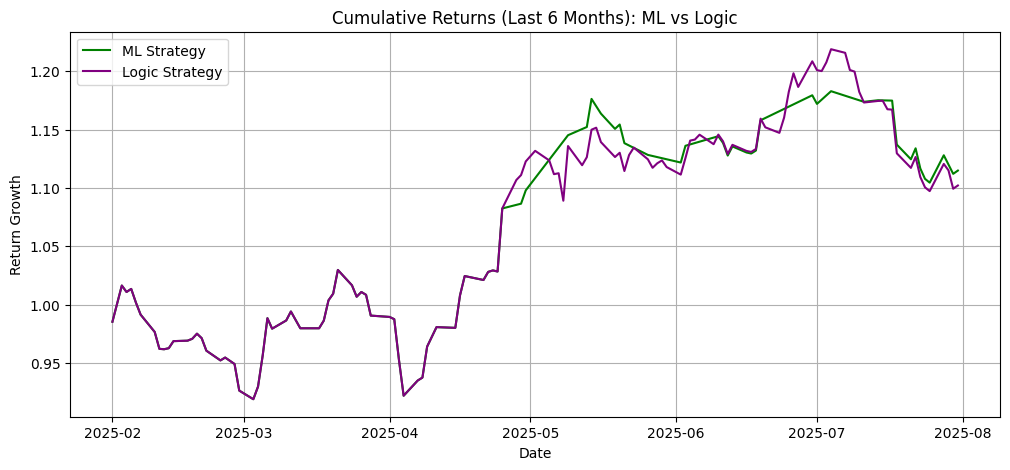

In [ ]:
import matplotlib.pyplot as plt

# ML strategy
ml_trades = df_recent[df_recent["ML_Prediction"] == 1].copy()
ml_trades["Return"] = df_recent["Close"].pct_change().shift(-1)
ml_trades["Cumulative"] = (1 + ml_trades["Return"]).cumprod()

# Logic strategy
logic_trades = df_recent[df_recent["Logic_Signal"] == 1].copy()
logic_trades["Return"] = df_recent["Close"].pct_change().shift(-1)
logic_trades["Cumulative"] = (1 + logic_trades["Return"]).cumprod()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(ml_trades.index, ml_trades["Cumulative"], label="ML Strategy", color="green")
plt.plot(logic_trades.index, logic_trades["Cumulative"], label="Logic Strategy", color="purple")
plt.title("Cumulative Returns (Last 6 Months): ML vs Logic")
plt.xlabel("Date")
plt.ylabel("Return Growth")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Make sure this runs after ML predictions and logic signals are already added to `df_recent`

# Step 1: Find agreement days
df_agreed = df_recent[(df_recent["ML_Prediction"] == 1) & (df_recent["Buy_Signal"] == 1)].copy()

# Step 2: Drop rows with missing next-day return
df_agreed = df_agreed.dropna(subset=["Trade_Return"])

# Step 3: Add performance columns
df_agreed["Profitable"] = df_agreed["Trade_Return"] > 0

# Step 4: Display key metrics
print("\n📅 RELIANCE - Agreement Trade Details (Last 6 Months)")
print(f"Total Agreement Trades: {len(df_agreed)}")
print(f"✅ Profitable Trades: {df_agreed['Profitable'].sum()}")
print(f"❌ Losing Trades: {(~df_agreed['Profitable']).sum()}")
print(f"🎯 Win Rate: {round(df_agreed['Profitable'].mean() * 100, 2)}%")
print(f"💰 Avg Return: {round(df_agreed['Trade_Return'].mean() * 100, 2)}%")

# Optional: Show sample agreement days
print("\n📅 Sample Agreement Days:")
print(df_agreed[["Close", "RSI", "SMA_20", "SMA_50", "Trade_Return", "Profitable"]].head(10))


📅 RELIANCE - Agreement Trade Details (Last 6 Months)
Total Agreement Trades: 0
✅ Profitable Trades: 0
❌ Losing Trades: 0
🎯 Win Rate: nan%
💰 Avg Return: nan%

📅 Sample Agreement Days:
Empty DataFrame
Columns: [Close, RSI, SMA_20, SMA_50, Trade_Return, Profitable]
Index: []


# test


Fetching data for INFY.NS

=== Analysis for INFY.NS ===
Data from 2020-10-12 00:00:00+05:30 to 2025-08-01 00:00:00+05:30
Index timezone: Asia/Kolkata
Train data points: 1068, Test data points: 122


/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:52] WARNING

Best Parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50}

=== ML Model Performance ===
Accuracy: 48.36%
Precision: 48.98%
Recall: 78.69%
F1-Score: 60.38%

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.18      0.26        61
           1       0.49      0.79      0.60        61

    accuracy                           0.48       122
   macro avg       0.47      0.48      0.43       122
weighted avg       0.47      0.48      0.43       122



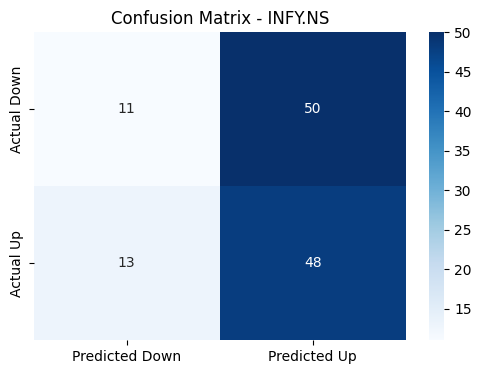


=== ML Trading Performance ===
Total Trades: 97
Profitable Trades: 45
Win Ratio: 46.39%
Avg Profit: 0.89%
Avg Loss: -1.31%
Cumulative Return: -25.19%


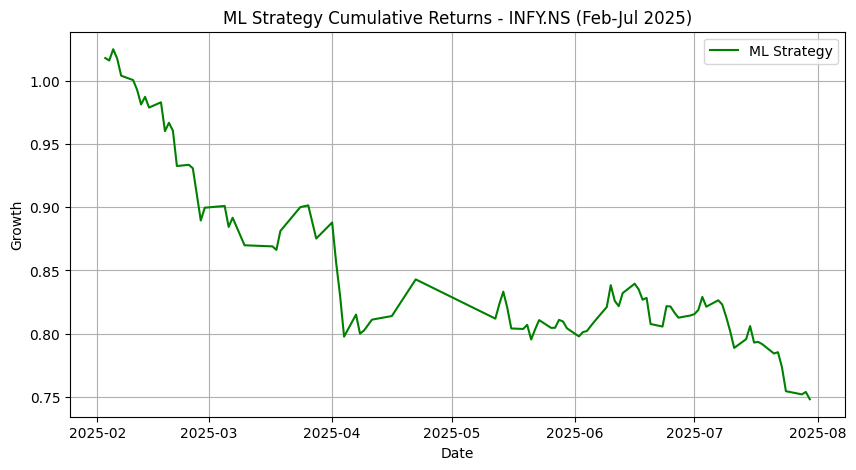


=== Rule-Based Strategy Performance ===
Total Trades: 2
Profitable Trades: 0
Win Ratio: 0.00%
Avg Profit: 0.00%
Avg Loss: -0.17%
Cumulative Return: -0.33%


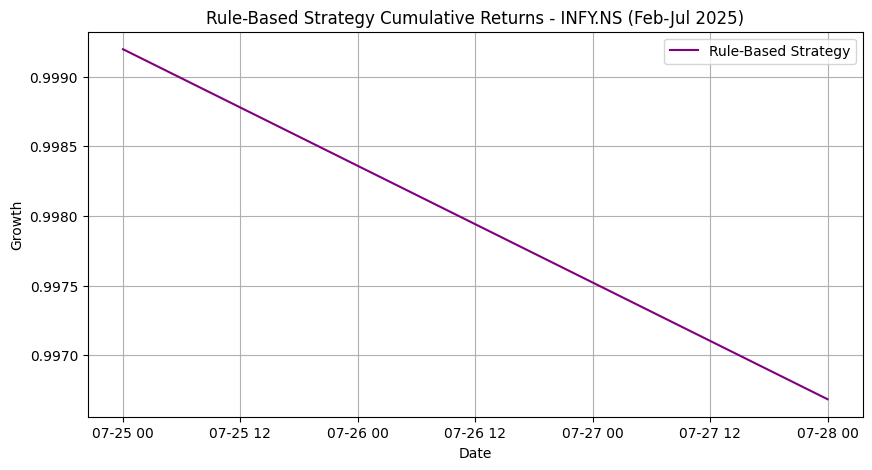


=== Agreement Trade Details ===
Total Agreement Trades: 2
Profitable Trades: 0
Win Ratio: 0.00%
Avg Return: -0.17%

Fetching data for RELIANCE.NS

=== Analysis for RELIANCE.NS ===
Data from 2020-10-12 00:00:00+05:30 to 2025-08-01 00:00:00+05:30
Index timezone: Asia/Kolkata
Train data points: 1068, Test data points: 122


/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:55] WARNING

Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}

=== ML Model Performance ===
Accuracy: 50.82%
Precision: 50.00%
Recall: 43.33%
F1-Score: 46.43%

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.58      0.55        62
           1       0.50      0.43      0.46        60

    accuracy                           0.51       122
   macro avg       0.51      0.51      0.50       122
weighted avg       0.51      0.51      0.51       122



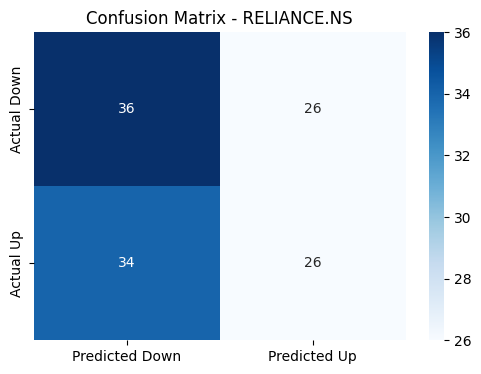


=== ML Trading Performance ===
Total Trades: 51
Profitable Trades: 24
Win Ratio: 47.06%
Avg Profit: 1.42%
Avg Loss: -0.89%
Cumulative Return: 9.93%


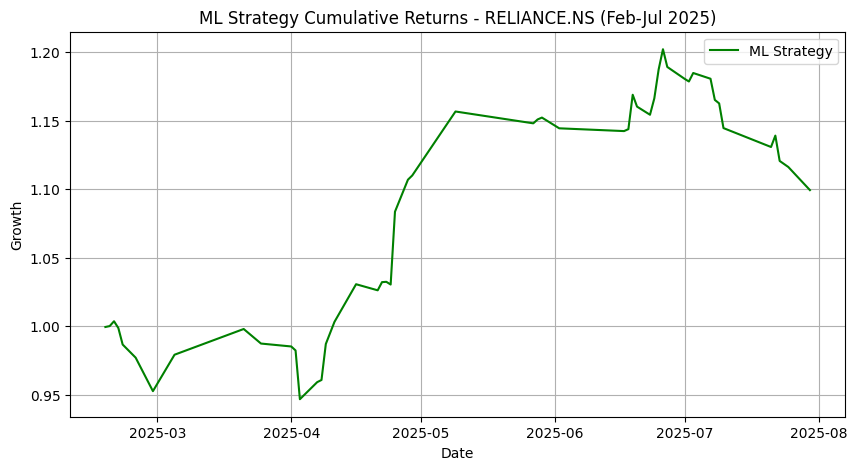


=== Rule-Based Strategy Performance ===
Total Trades: 5
Profitable Trades: 2
Win Ratio: 40.00%
Avg Profit: 10.59%
Avg Loss: -0.70%
Cumulative Return: 18.68%


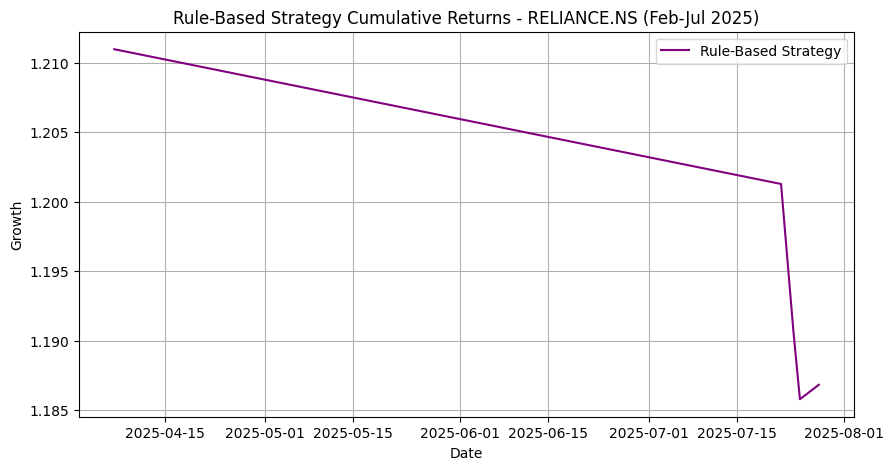


=== Agreement Trade Details ===
Total Agreement Trades: 2
Profitable Trades: 1
Win Ratio: 50.00%
Avg Return: 9.75%

Fetching data for HDFCBANK.NS

=== Analysis for HDFCBANK.NS ===
Data from 2020-10-12 00:00:00+05:30 to 2025-08-01 00:00:00+05:30
Index timezone: Asia/Kolkata
Train data points: 1068, Test data points: 122


/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "class_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:25:57] WARNING

Best Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 150}

=== ML Model Performance ===
Accuracy: 45.90%
Precision: 55.56%
Recall: 21.74%
F1-Score: 31.25%

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.77      0.55        53
           1       0.56      0.22      0.31        69

    accuracy                           0.46       122
   macro avg       0.49      0.50      0.43       122
weighted avg       0.50      0.46      0.42       122



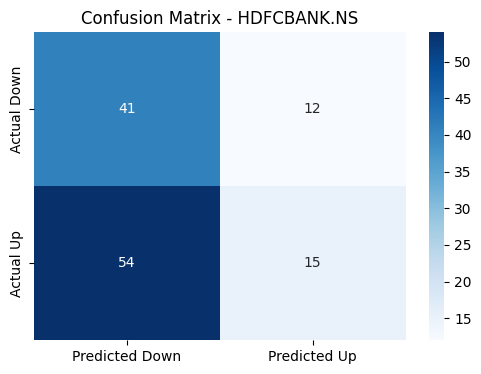


=== ML Trading Performance ===
Total Trades: 27
Profitable Trades: 13
Win Ratio: 48.15%
Avg Profit: 1.22%
Avg Loss: -1.04%
Cumulative Return: 1.01%


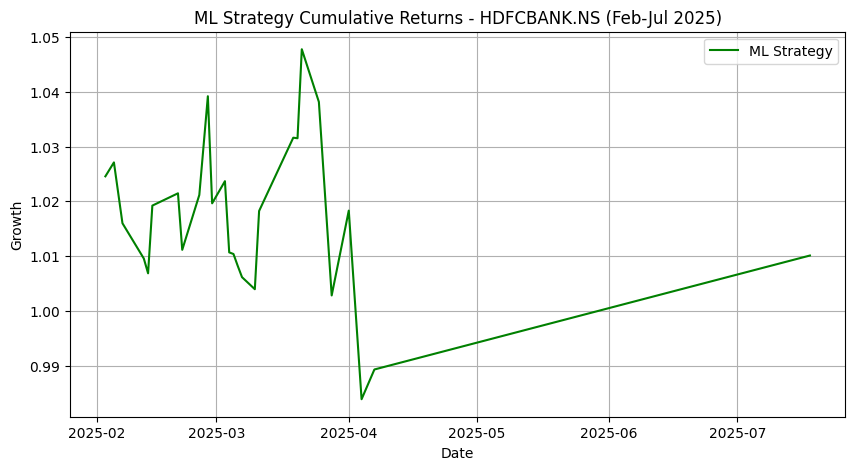


=== Rule-Based Strategy Performance ===
Total Trades: 0
Profitable Trades: 0
Win Ratio: 0.00%
Avg Profit: 0.00%
Avg Loss: 0.00%
Cumulative Return: 0.00%


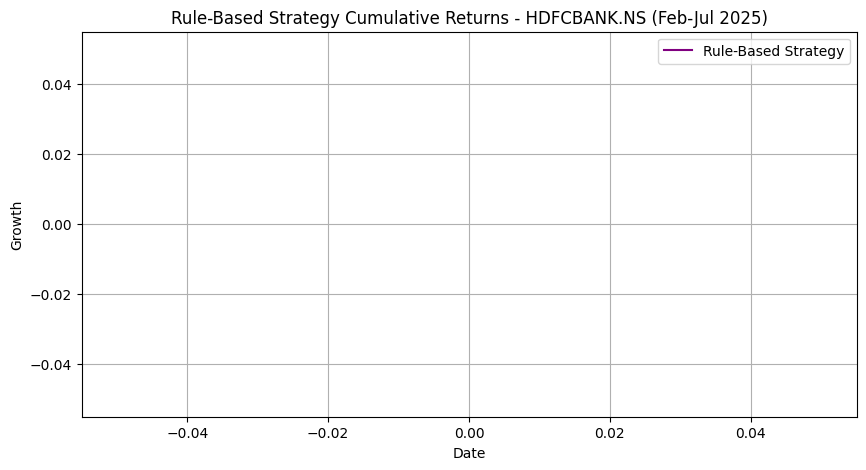


=== Agreement Trade Details ===
Total Agreement Trades: 0
Profitable Trades: 0
Win Ratio: 0.00%
Avg Return: 0.00%

Sample processed data for INFY.NS:
                                 Close        RSI       MACD       SMA_20  \
Date                                                                        
2025-07-28 00:00:00+05:30  1516.000000  32.516792 -15.451989  1591.704999   
2025-07-29 00:00:00+05:30  1513.699951  32.118653 -18.410624  1587.049994   
2025-07-30 00:00:00+05:30  1519.000000  34.120385 -20.096039  1582.474994   
2025-07-31 00:00:00+05:30  1509.000000  32.191520 -21.985228  1576.989996   
2025-08-01 00:00:00+05:30  1469.599976  25.963703 -26.357839  1568.434998   

                                SMA_50  Buy_Signal  Target  
Date                                                        
2025-07-28 00:00:00+05:30  1585.859570           1       0  
2025-07-29 00:00:00+05:30  1585.354634           1       1  
2025-07-30 00:00:00+05:30  1584.799890           0       0  
2025

In [341]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta.momentum import RSIIndicator
from ta.trend import MACD
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Define symbols and period
symbols = ["INFY.NS", "RELIANCE.NS", "HDFCBANK.NS"]
period = "5y"
# Use timezone-aware timestamps
backtest_start = pd.to_datetime("2025-02-01", utc=True).tz_convert("Asia/Kolkata")
backtest_end = pd.to_datetime("2025-07-31", utc=True).tz_convert("Asia/Kolkata")

# Preprocessing function (same as original)
def preprocess_stock(df, rsi_threshold=35):
    df = df.copy()
    
    # Technical Indicators
    df["RSI"] = RSIIndicator(df["Close"], window=14).rsi()
    df["MACD"] = MACD(df["Close"]).macd()
    df["MACD_Signal"] = MACD(df["Close"]).macd_signal()
    df["SMA_20"] = df["Close"].rolling(window=20).mean()
    df["SMA_50"] = df["Close"].rolling(window=50).mean()
    df["EMA_20"] = df["Close"].ewm(span=20, adjust=False).mean()
    df["Volatility"] = df["Close"].rolling(window=10).std()
    
    # Strategy Signals (RSI < 35 and SMA_20 > SMA_50)
    df["Buy_Signal"] = ((df["RSI"] < rsi_threshold) & (df["SMA_20"] > df["SMA_50"])).astype(int)
    df["Logic_Signal"] = df["Buy_Signal"]  # For ML vs. Logic comparison
    df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)  # Next-day price increase
    
    # Ensure datetime index is timezone-aware
    df.index = pd.to_datetime(df.index).tz_convert("Asia/Kolkata")
    return df.dropna()

# Analysis function for each stock
def run_analysis(symbol, data):
    print(f"\n=== Analysis for {symbol} ===")
    
    # Preprocess data
    processed_data = preprocess_stock(data)
    
    # Verify date range
    print(f"Data from {processed_data.index.min()} to {processed_data.index.max()}")
    
    # Check timezone of index
    print(f"Index timezone: {processed_data.index.tz}")
    
    # Features and target
    features = ["RSI", "MACD", "MACD_Signal", "SMA_20", "EMA_20", "Volatility"]
    X = processed_data[features]
    y = processed_data["Target"]
    
    # Split data: train (before Feb 2025), test (Feb 2025 - Jul 2025)
    train = processed_data[processed_data.index < backtest_start]
    test = processed_data[(processed_data.index >= backtest_start) & (processed_data.index <= backtest_end)]
    
    if len(test) == 0:
        print(f"Error: No data available for {symbol} in backtest period.")
        return None, None
    
    print(f"Train data points: {len(train)}, Test data points: {len(test)}")
    
    # Train XGBoost model
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [2, 3, 4],
        'learning_rate': [0.01, 0.1, 0.2],
    }
    grid = GridSearchCV(
        estimator=XGBClassifier(random_state=42, class_weight='balanced'),
        param_grid=param_grid,
        scoring='precision',
        cv=TimeSeriesSplit(n_splits=5),
        verbose=0,
        n_jobs=-1
    )
    grid.fit(train[features], train["Target"])
    best_model = grid.best_estimator_
    print("Best Parameters:", grid.best_params_)
    
    # Backtest: ML Strategy
    X_test = test[features]
    y_test = test["Target"]
    y_pred = best_model.predict(X_test)
    
    # Model performance
    print("\n=== ML Model Performance ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
    print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.2%}")
    print(f"Recall: {recall_score(y_test, y_pred, zero_division=0):.2%}")
    print(f"F1-Score: {f1_score(y_test, y_pred, zero_division=0):.2%}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Down', 'Predicted Up'],
                yticklabels=['Actual Down', 'Actual Up'])
    plt.title(f"Confusion Matrix - {symbol}")
    plt.show()
    
    # Simulate ML trades
    backtest_df = test.copy()
    backtest_df["ML_Prediction"] = y_pred
    backtest_df["Buy_Price"] = backtest_df["Close"].where(backtest_df["ML_Prediction"] == 1)
    backtest_df["Sell_Price"] = backtest_df["Close"].shift(-1).where(backtest_df["ML_Prediction"] == 1)
    backtest_df["Trade_Return"] = ((backtest_df["Sell_Price"] - backtest_df["Buy_Price"]) / 
                                   backtest_df["Buy_Price"] - 0.001)  # 0.1% transaction cost
    backtest_df = backtest_df.dropna(subset=["Trade_Return"])
    
    # ML trading metrics
    total_trades_ml = len(backtest_df)
    profitable_trades_ml = (backtest_df["Trade_Return"] > 0).sum()
    win_ratio_ml = profitable_trades_ml / total_trades_ml if total_trades_ml > 0 else 0
    avg_profit_ml = backtest_df[backtest_df["Trade_Return"] > 0]["Trade_Return"].mean() if profitable_trades_ml > 0 else 0
    avg_loss_ml = backtest_df[backtest_df["Trade_Return"] <= 0]["Trade_Return"].mean() if (total_trades_ml - profitable_trades_ml) > 0 else 0
    cumulative_return_ml = (1 + backtest_df["Trade_Return"]).prod() - 1
    
    print("\n=== ML Trading Performance ===")
    print(f"Total Trades: {total_trades_ml}")
    print(f"Profitable Trades: {profitable_trades_ml}")
    print(f"Win Ratio: {win_ratio_ml:.2%}")
    print(f"Avg Profit: {avg_profit_ml:.2%}")
    print(f"Avg Loss: {avg_loss_ml:.2%}")
    print(f"Cumulative Return: {cumulative_return_ml:.2%}")
    
    # Plot ML cumulative returns
    plt.figure(figsize=(10, 5))
    plt.plot(backtest_df.index, (1 + backtest_df["Trade_Return"]).cumprod(),
             label="ML Strategy", color="green")
    plt.title(f"ML Strategy Cumulative Returns - {symbol} (Feb-Jul 2025)")
    plt.xlabel("Date")
    plt.ylabel("Growth")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Simulate Rule-Based Strategy
    strategy_signals = test[test["Buy_Signal"] == 1].copy()
    strategy_signals["Trade_Return"] = ((strategy_signals["Close"].shift(-1) - 
                                        strategy_signals["Close"]) / 
                                       strategy_signals["Close"] - 0.001)
    strategy_signals = strategy_signals.dropna(subset=["Trade_Return"])
    
    total_trades_rule = len(strategy_signals)
    profitable_trades_rule = (strategy_signals["Trade_Return"] > 0).sum()
    win_ratio_rule = profitable_trades_rule / total_trades_rule if total_trades_rule > 0 else 0
    avg_profit_rule = strategy_signals[strategy_signals["Trade_Return"] > 0]["Trade_Return"].mean() if profitable_trades_rule > 0 else 0
    avg_loss_rule = strategy_signals[strategy_signals["Trade_Return"] <= 0]["Trade_Return"].mean() if (total_trades_rule - profitable_trades_rule) > 0 else 0
    cumulative_return_rule = (1 + strategy_signals["Trade_Return"]).prod() - 1
    
    print("\n=== Rule-Based Strategy Performance ===")
    print(f"Total Trades: {total_trades_rule}")
    print(f"Profitable Trades: {profitable_trades_rule}")
    print(f"Win Ratio: {win_ratio_rule:.2%}")
    print(f"Avg Profit: {avg_profit_rule:.2%}")
    print(f"Avg Loss: {avg_loss_rule:.2%}")
    print(f"Cumulative Return: {cumulative_return_rule:.2%}")
    
    # Plot rule-based cumulative returns
    plt.figure(figsize=(10, 5))
    plt.plot(strategy_signals.index, (1 + strategy_signals["Trade_Return"]).cumprod(),
             label="Rule-Based Strategy", color="purple")
    plt.title(f"Rule-Based Strategy Cumulative Returns - {symbol} (Feb-Jul 2025)")
    plt.xlabel("Date")
    plt.ylabel("Growth")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Agreement Analysis (Fixed: Use backtest_df instead of test)
    df_agreed = backtest_df[(backtest_df["ML_Prediction"] == 1) & (backtest_df["Buy_Signal"] == 1)].copy()
    df_agreed["Trade_Return"] = ((df_agreed["Close"].shift(-1) - df_agreed["Close"]) / 
                                 df_agreed["Close"] - 0.001)
    df_agreed = df_agreed.dropna(subset=["Trade_Return"])
    
    total_agreed = len(df_agreed)
    profitable_agreed = (df_agreed["Trade_Return"] > 0).sum()
    win_ratio_agreed = profitable_agreed / total_agreed if total_agreed > 0 else 0
    avg_return_agreed = df_agreed["Trade_Return"].mean() if total_agreed > 0 else 0
    
    print("\n=== Agreement Trade Details ===")
    print(f"Total Agreement Trades: {total_agreed}")
    print(f"Profitable Trades: {profitable_agreed}")
    print(f"Win Ratio: {win_ratio_agreed:.2%}")
    print(f"Avg Return: {avg_return_agreed:.2%}")
    
    # Store processed data and model
    return processed_data, best_model

# Run analysis for each stock and store processed DataFrames
processed_data_dict = {}
models_dict = {}

for symbol in symbols:
    print(f"\nFetching data for {symbol}")
    data = yf.Ticker(symbol).history(period=period)
    if data.empty:
        print(f"Error: No data retrieved for {symbol}")
        continue
    processed_data, best_model = run_analysis(symbol, data)
    if processed_data is not None:
        processed_data_dict[symbol] = processed_data
        models_dict[symbol] = best_model

# Access processed DataFrames
processed_infy = processed_data_dict.get("INFY.NS")
processed_reliance = processed_data_dict.get("RELIANCE.NS")
processed_hdfcbank = processed_data_dict.get("HDFCBANK.NS")

# Print sample data for verification
for symbol, df in processed_data_dict.items():
    print(f"\nSample processed data for {symbol}:")
    print(df[["Close", "RSI", "MACD", "SMA_20", "SMA_50", "Buy_Signal", "Target"]].tail())